<table style="border:2px solid white;" cellspacing="0" cellpadding="0" border-collapse: collapse; border-spacing: 0;>
  <tr> 
    <th style="background-color:white"> <img src="../media/CCAL.png" width=225 height=225></th>
    <th style="background-color:white"> <img src="../media/logoMoores.jpg" width=175 height=175></th>
    <th style="background-color:white"> <img src="../media/GP.png" width=200 height=200></th>
    <th style="background-color:white"> <img src="../media/UCSD_School_of_Medicine_logo.png" width=175 height=175></th> 
    <th style="background-color:white"> <img src="../media/Broad.png" width=130 height=130></th> 
  </tr>
</table>


<hr style="border: none; border-bottom: 3px solid #88BBEE;">
# **Onco-*GPS* Methodology**
## **Chapter 5. Annotating the Oncogenic States**


**Authors:** Huwate (Kwat) Yeerna -  *Computational Cancer Analysis Laboratory (CCAL), UCSD Moores Cancer Center*  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
 William Kim - Cancer Program, *Eli and Edythe Broad Institute*      
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
Taylor Cavazos - *Computational Cancer Analysis Laboratory (CCAL), UCSD Moores Cancer Center*   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
Kate Medetgul-Ernar - *Computational Cancer Analysis Laboratory (CCAL), UCSD Moores Cancer Center*   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
Clarence Mah - *Mesirov Lab, UCSD School of Medicine and Moores Cancer Center*      
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
Jill P. Mesirov - *Mesirov Lab, UCSD School of Medicine and Moores Cancer Center*  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
Pablo Tamayo - *Computational Cancer Analysis Laboratory (CCAL), UCSD Moores Cancer Center* 

**Date:** Jan 5, 2017

**Article:** [*Kim et al.* Decomposing Oncogenic Transcriptional Signatures to Generate Maps of Divergent Cellular States](https://drive.google.com/file/d/0B0MQqMWLrsA4b2RUTTAzNjFmVkk/view?usp=sharing)

**Analysis overview:** 
In this notebook we perform a detailed analysis and annotation of the KRAS mutant oncogenic states (S1-S4) in order to assign a biological interpretation to each component. This analysis is very similar to the one we performed in the "Onco-GPS: Annotating the Transcriptional Components" notebook (see that notebook for additional details). The main difference is that in this notebook we will use as target profiles binary variables representing the membership of samples to each of the oncogenic states, rather than the transcriptional component profiles.

As in the case of annotating the transcriptional component the genomic features include the following:

1. **Mutations and Copy Number Alterations (CNA).** CCLE mutation and copy number datasets (www.broadinstitute.org/ccle, [*Barretina et al. 2012*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3320027/)).
2.	 **Gene expression.** CCLE RNA Seq dataset (http://www.broadinstitute.org/ccle, [*Barretina et al. 2012*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3320027/)).
3.	  **Pathway expression** (single sample GSEA of MSigDB gene sets) MSigDB v5.1 sub-collections c2, c5, c6 and h www.msigdb.org, (Liberzon et al. 2011; [*Liberzon et al. 2016. Cell Systems, 1(6), pp.417–425.*](https://www.ncbi.nlm.nih.gov/pubmed/26771021). and a few additional gene sets (see supplementary information in the article).
4.	**TF and master regulators expression** (single sample GSEA of gene sets) MSigDB v5.1, ([*Liberzon et al. 2011*](https://www.ncbi.nlm.nih.gov/pubmed/21546393)) http://www.msigdb.org, sub-collection c3 and 1,598 IPA gene sets, http://www.ingenuity.com.
5.	 **Protein expression.** CCLE Reverse Phased Protein Array (RPPA) dataset (http://www.broadinstitute.org/ccle, [*Barretina et al. 2012*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3320027/)).
6.	 **Drug sensitivity.** CCLE dataset (http://www.broadinstitute.org/ccle, [*Barretina et al. 2012*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3320027/))
7.	**Gene dependency.** RNAi Achilles dataset, http://www.broadinstitute.org/achilles, ([*Cowley et al. 2014*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4432652/)).

Go to the [next chapter (6)](6 Onco-GPS -- Displaying Selected Genomic Features in the KRAS mut Onco-GPS Map.ipynb).
Back to the [introduction (0)](0 Onco-GPS -- Introduction and Overview.ipynb).

<hr style="border: none; border-bottom: 3px solid #88BBEE;">
### 1. Set up notebook and import Computational Cancer Analysis Library ([CCAL](https://github.com/KwatME/ccal))

In [1]:
import sys
import os
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (8, 5)
mpl.rcParams['figure.max_open_warning'] = 100
HOME_DIR = os.environ['HOME']
sys.path.insert(0, os.path.join(HOME_DIR, 'ccal'))
import ccal

<hr style="border: none; border-bottom: 3px solid #88BBEE;">
### 2. Set data and result directories
These are the directories where the output and intermediate files will be stored

In [2]:
DATA_DIR = HOME_DIR + '/OncoGPS_Analysis2/data'
RESULTS_DIR = HOME_DIR + '/OncoGPS_Analysis2/results'

<hr style="border: none; border-bottom: 3px solid #88BBEE;">
### 3. Load the annotation datasets

<hr style="border: none; border-bottom: 1px solid #88BBEE;">
#### 3.1 Define the genomic annotation datasets

In [3]:
MUT_CNA_DATASET = DATA_DIR + '/ccle_mut_cna.gct'
GENE_DEPENDENCY_DATASET = DATA_DIR +  '/ccle_gene_dependency.gct'
GENE_EXPRESSION_DATASET = DATA_DIR + '/rnaseq.v3.NO_HAEM.gct'
PATHWAY_EXPRESSION_DATASET = DATA_DIR + '/ccle_pathway_expression_all.gct'
REGULATOR_DATASET = DATA_DIR + '/ccle_regulator.gct'
PROTEIN_EXPRESSION_DATASET = DATA_DIR + '/ccle_protein_expression.gct'
TISSUE_DATASET = DATA_DIR + '/ccle_tissue.gct'
DRUG_SENSITIVITY_DATASET = DATA_DIR + '/ccle_drug_sensitivity.gct'

<hr style="border: none; border-bottom: 1px solid #88BBEE;">
#### 3.2 Read the genomic annotation datasets

In [4]:
mut_cna_df = ccal.read_gct(MUT_CNA_DATASET)
gene_dependency_df = ccal.read_gct(GENE_DEPENDENCY_DATASET)
gene_expression_df = ccal.read_gct(GENE_EXPRESSION_DATASET)
pathway_expression_df = ccal.read_gct(PATHWAY_EXPRESSION_DATASET)
regulator_df = ccal.read_gct(REGULATOR_DATASET)
protein_expression_df = ccal.read_gct(PROTEIN_EXPRESSION_DATASET)
tissue_df = ccal.read_gct(TISSUE_DATASET)
drug_sensitivity_df = ccal.read_gct(DRUG_SENSITIVITY_DATASET)

<hr style="border: none; border-bottom: 3px solid #88BBEE;">
### 4.  Annotate the oncogenic states using the Information Coefficent (IC) 
Each binary membership variable is used as a phenotype against which several types of genomic features are matched. 


<hr style="border: none; border-bottom: 1px solid #88BBEE;">
#### 4.1 Read clustering results and 4-state samples membership 

In [5]:
binary_labels = ccal.read_gct(RESULTS_DIR +  '/clusterings/clusterings_k4.gct')
kras_sample_labels = binary_labels.ix[5,:]

<hr style="border: none; border-bottom: 1px solid #88BBEE;">
#### 4.2 Define the set of genomic features that will be used to annotate the components

In [6]:
features_bundle = [
    ['Tissue Types', tissue_df, 'binary', False, 0, [], []],
    ['Protein Expression', protein_expression_df, 'continuous', False, 0, [], []],
    ['Mutations and CNA', mut_cna_df, 'binary', False, 0, [], []],
    ['Gene Dependency', gene_dependency_df, 'continuous', True, 0, [], []],
    ['Gene Expression', gene_expression_df, 'continuous', False, 0, [], []],
    ['Pathway Expression', pathway_expression_df, 'continuous', False, 0, [], []],
    ['Regulators', regulator_df, 'continuous', False, 0, [], []],
    ['Drug Sensitivity', drug_sensitivity_df, 'continuous', True, 0, [], []]
]

<hr style="border: none; border-bottom: 1px solid #88BBEE;">
#### 4.3 Annotate each state with all the feature datasets using information-based association (IC)

KRAS State S4 vs Tissue Types


/Users/tamayo/ccal/ccal/mathematics/information.py:87: RuntimeWarning: invalid value encountered in sqrt
  ic = sign(cor) * sqrt(1 - exp(- 2 * mi))


KRAS State S4 vs Protein Expression
KRAS State S4 vs Mutations and CNA
KRAS State S4 vs Gene Dependency
KRAS State S4 vs Gene Expression
KRAS State S4 vs Pathway Expression
KRAS State S4 vs Regulators
KRAS State S4 vs Drug Sensitivity
KRAS State S3 vs Tissue Types
KRAS State S3 vs Protein Expression
KRAS State S3 vs Mutations and CNA
KRAS State S3 vs Gene Dependency
KRAS State S3 vs Gene Expression
KRAS State S3 vs Pathway Expression
KRAS State S3 vs Regulators
KRAS State S3 vs Drug Sensitivity
KRAS State S2 vs Tissue Types
KRAS State S2 vs Protein Expression
KRAS State S2 vs Mutations and CNA
KRAS State S2 vs Gene Dependency
KRAS State S2 vs Gene Expression
KRAS State S2 vs Pathway Expression
KRAS State S2 vs Regulators
KRAS State S2 vs Drug Sensitivity
KRAS State S1 vs Tissue Types
KRAS State S1 vs Protein Expression
KRAS State S1 vs Mutations and CNA
KRAS State S1 vs Gene Dependency
KRAS State S1 vs Gene Expression
KRAS State S1 vs Pathway Expression
KRAS State S1 vs Regulators
KRAS

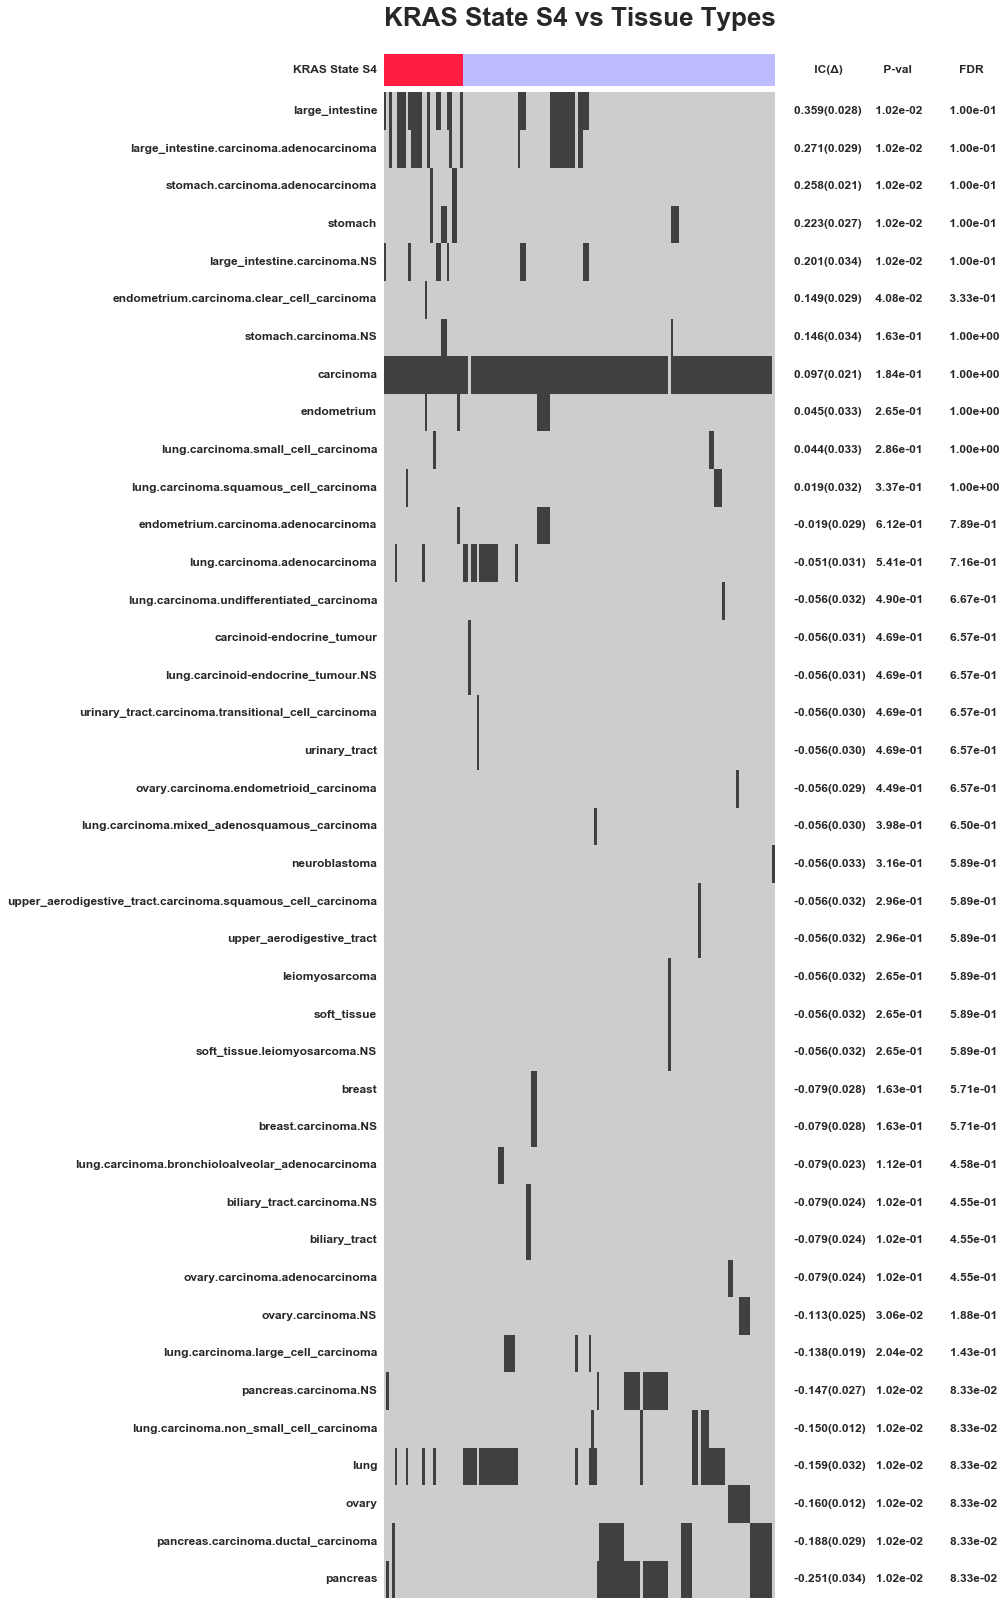

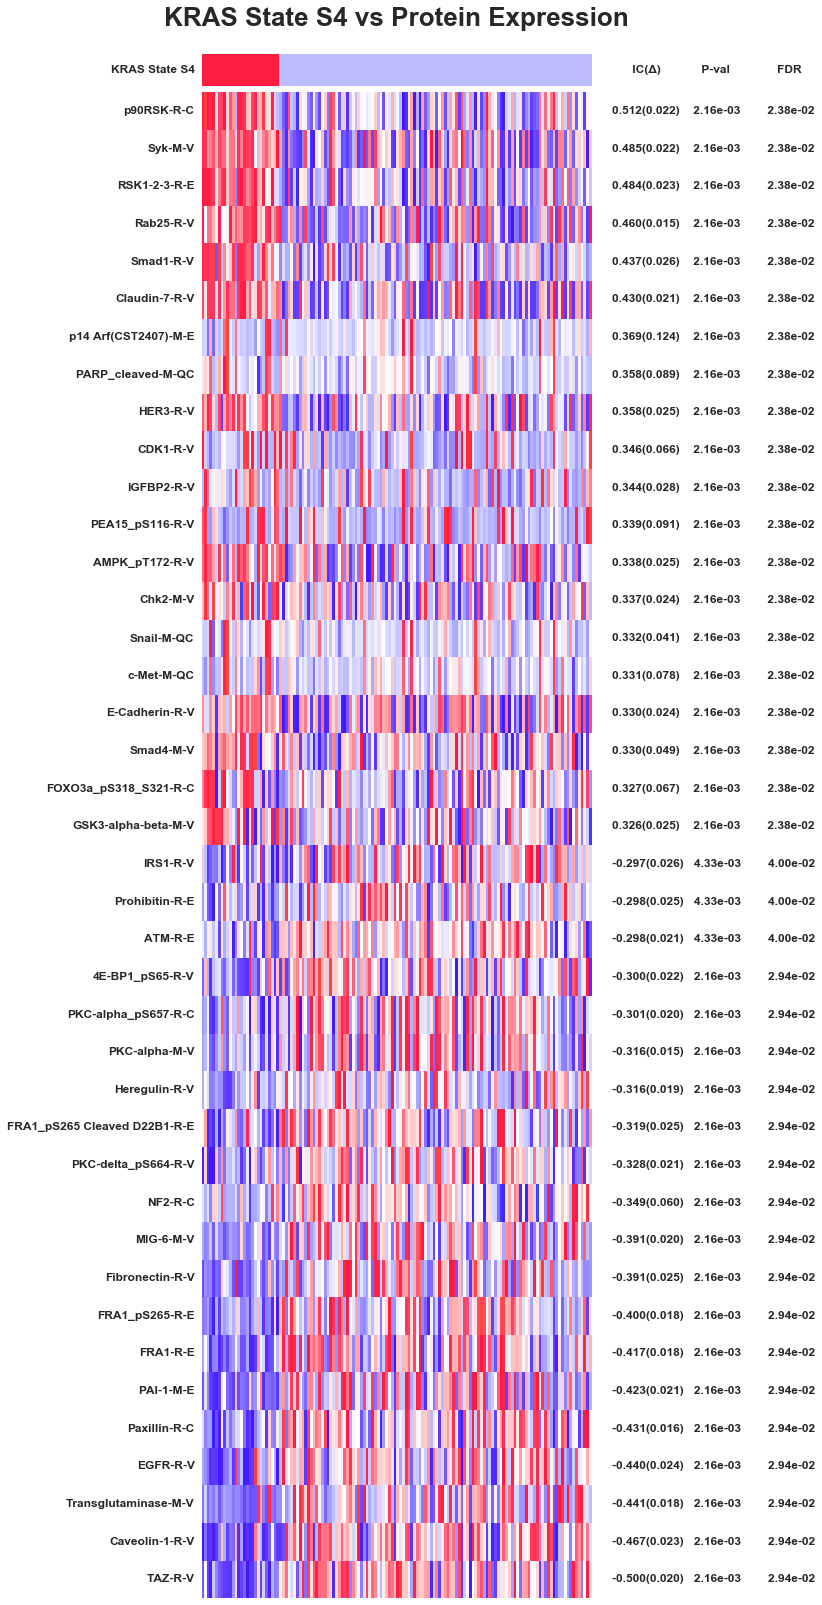

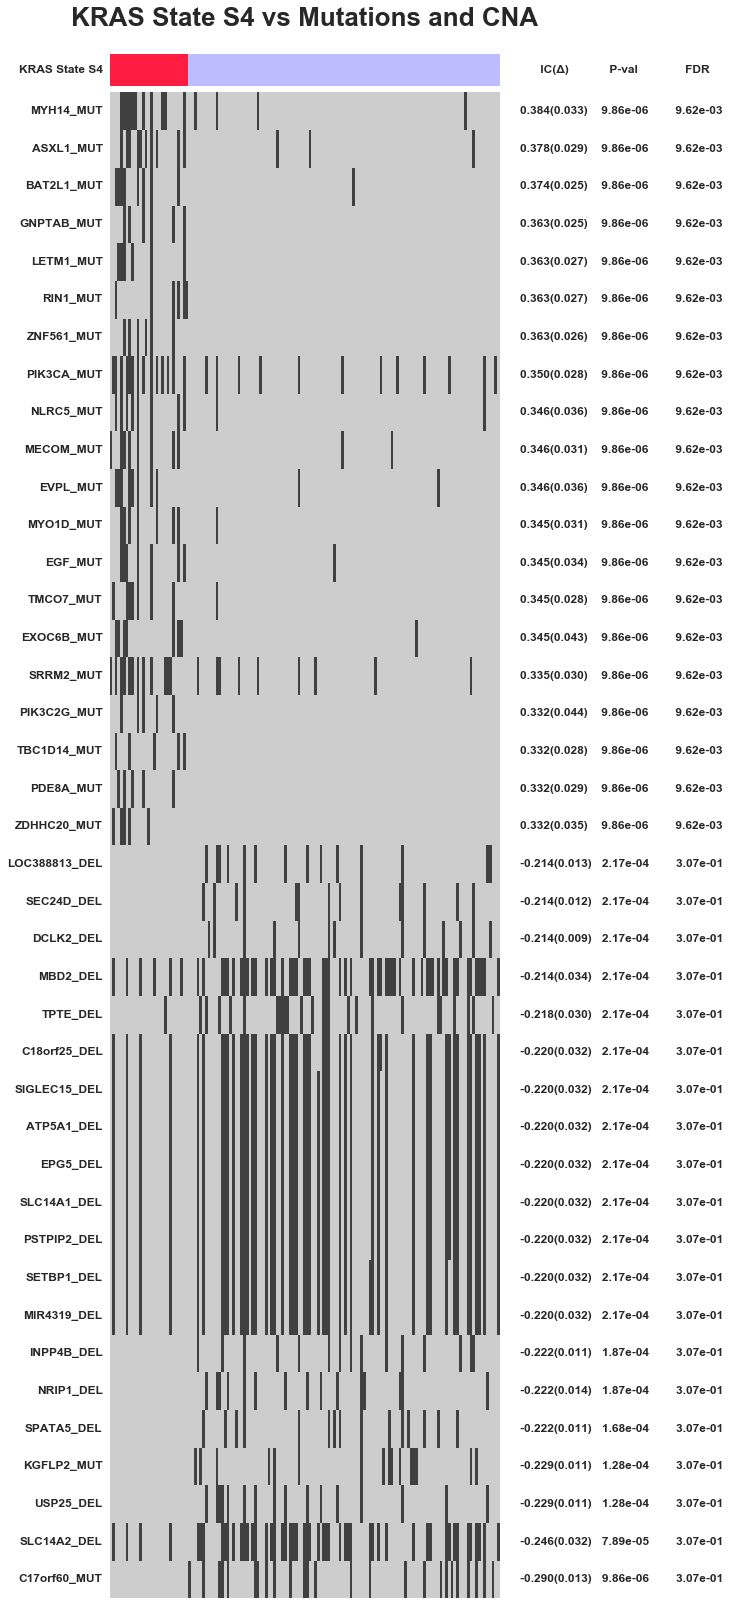

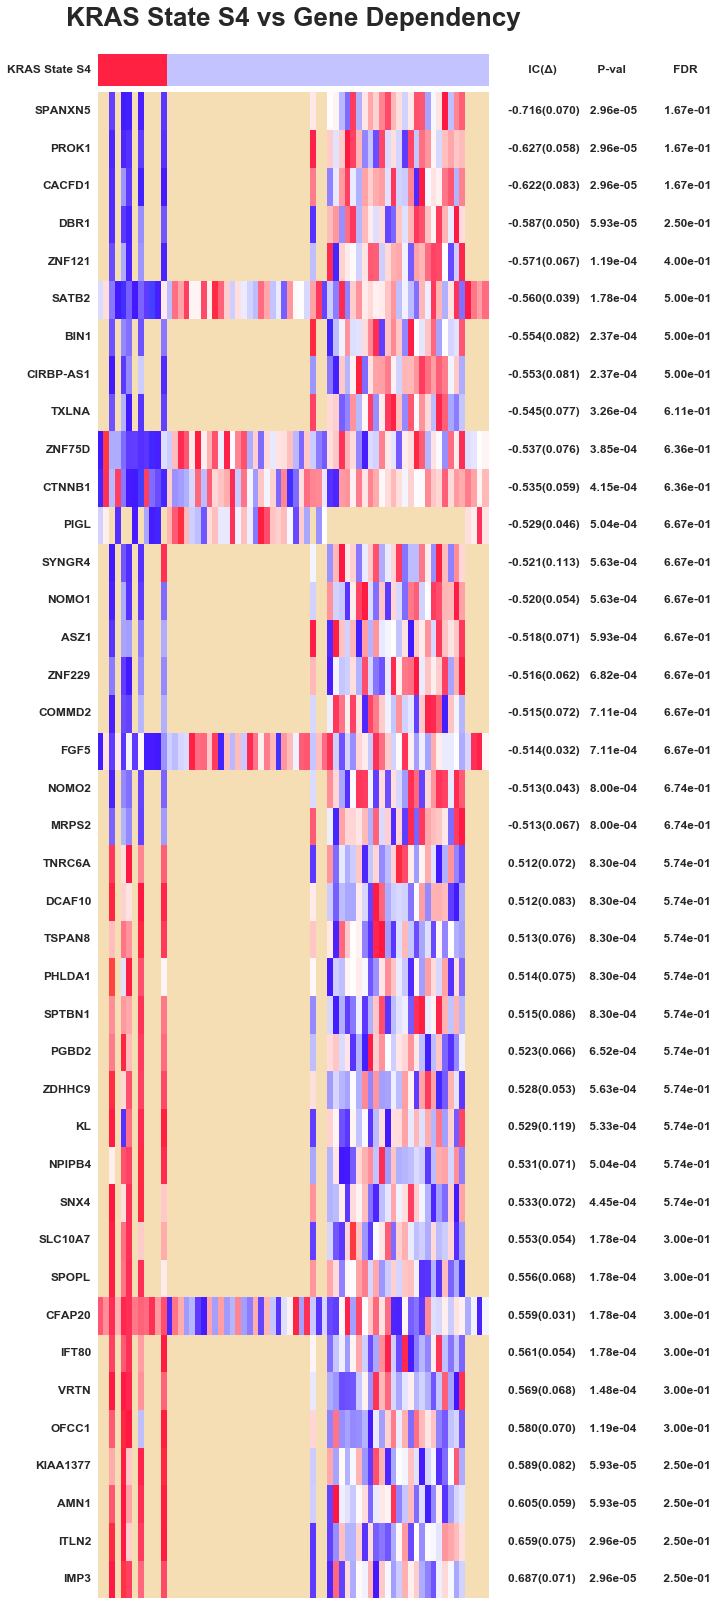

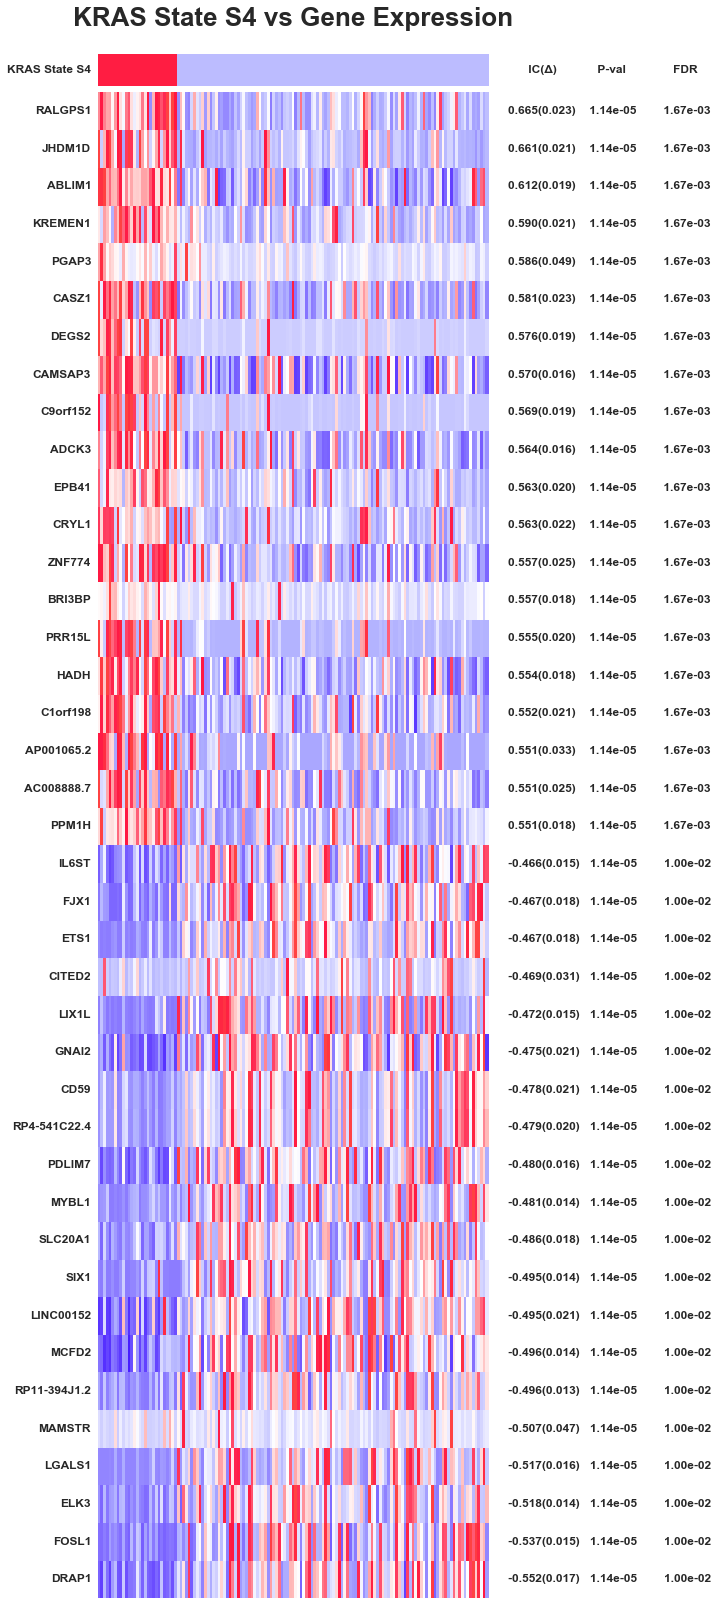

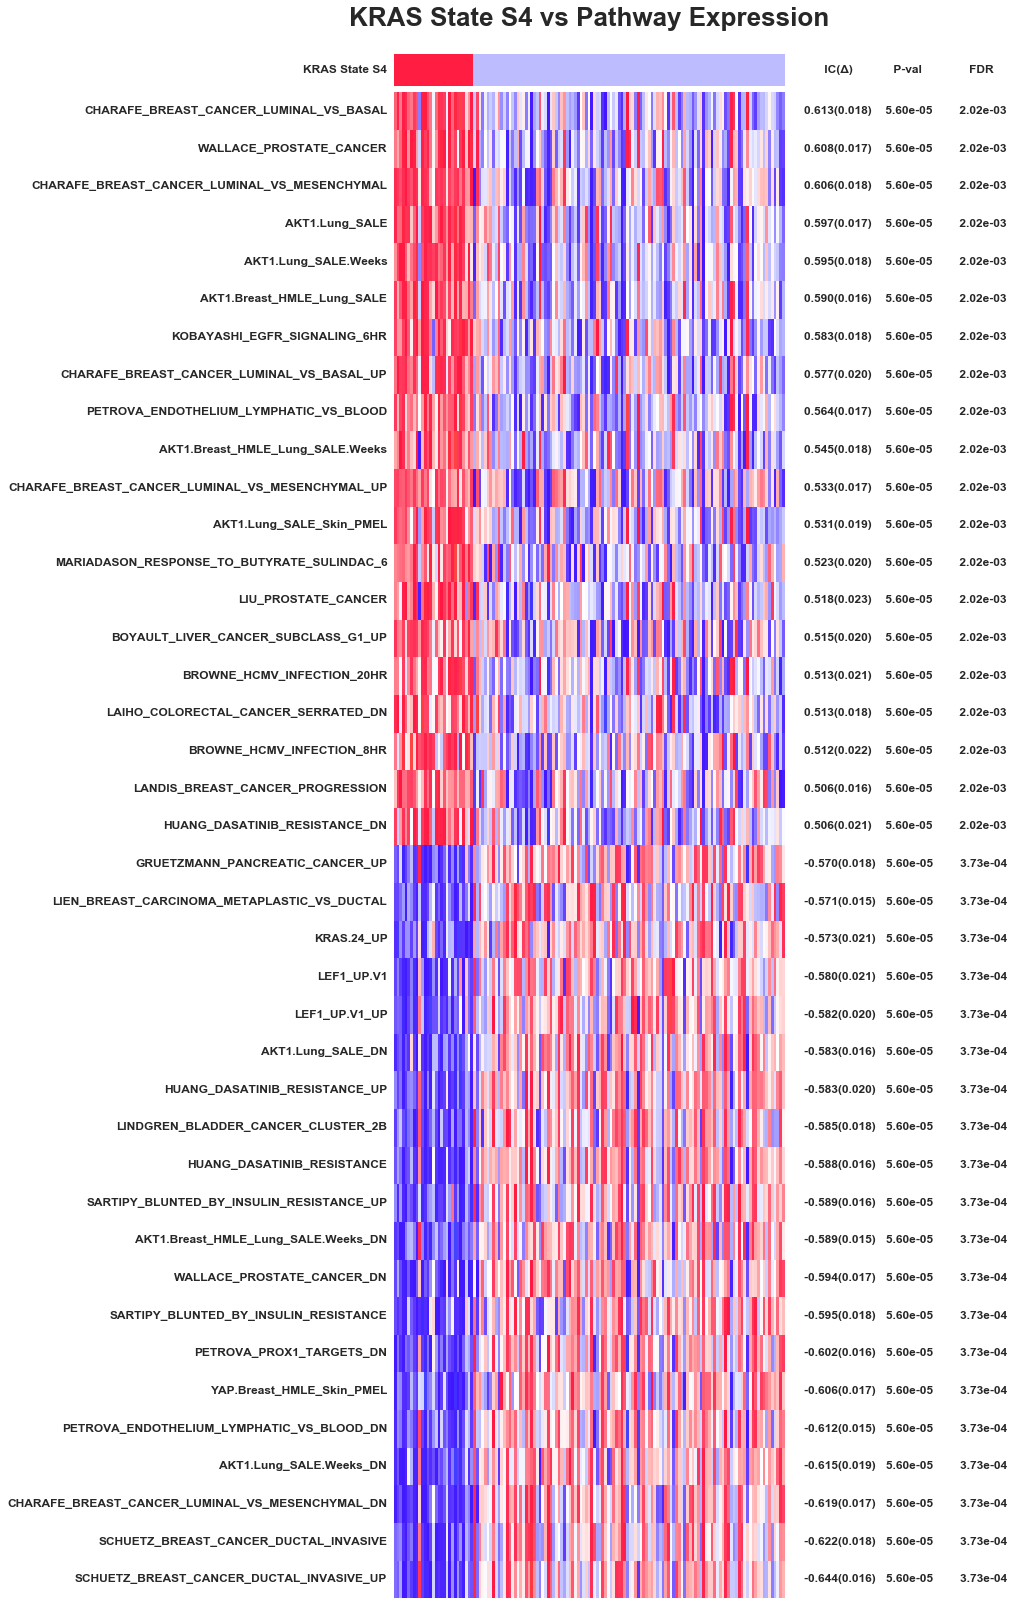

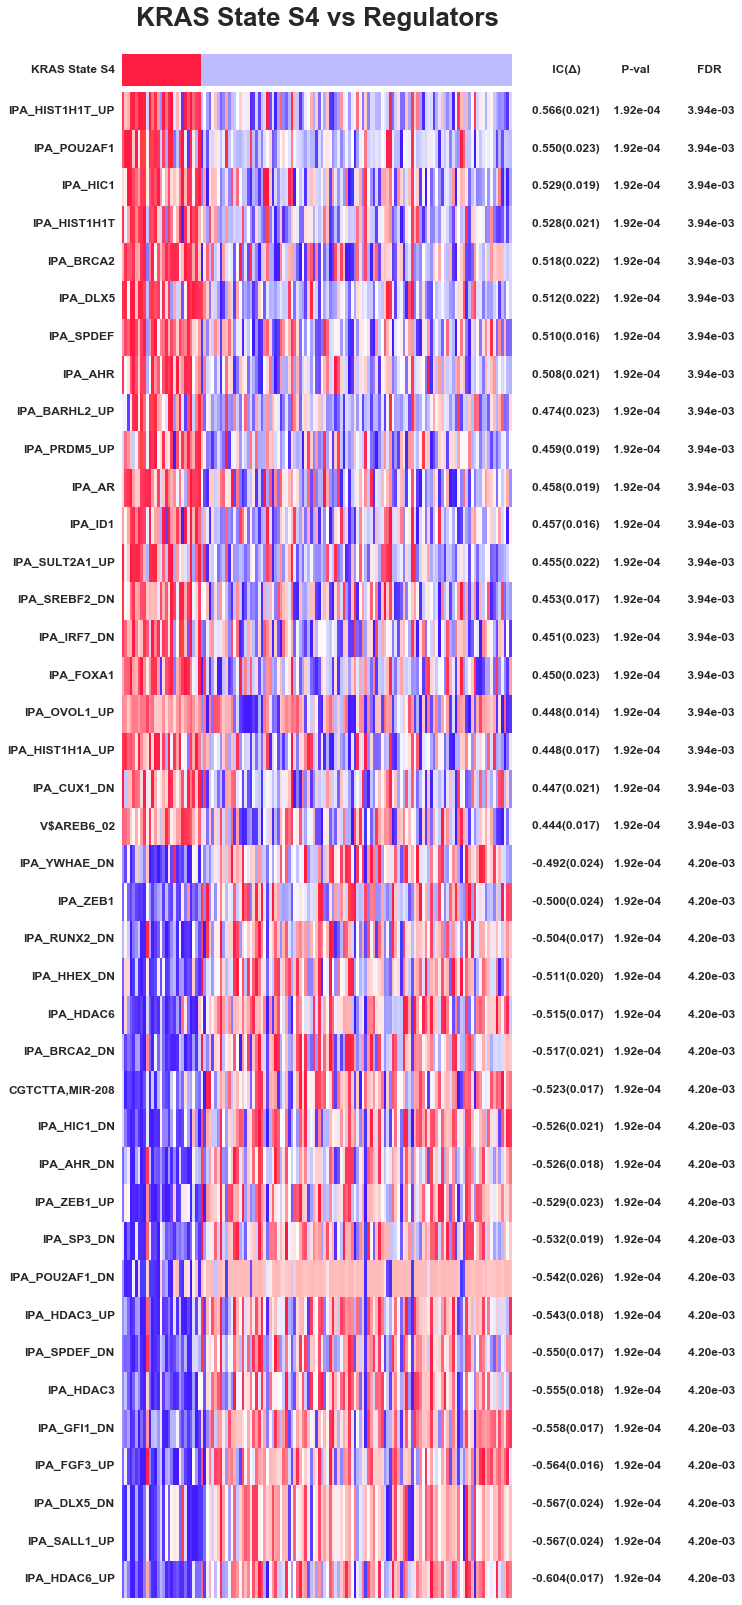

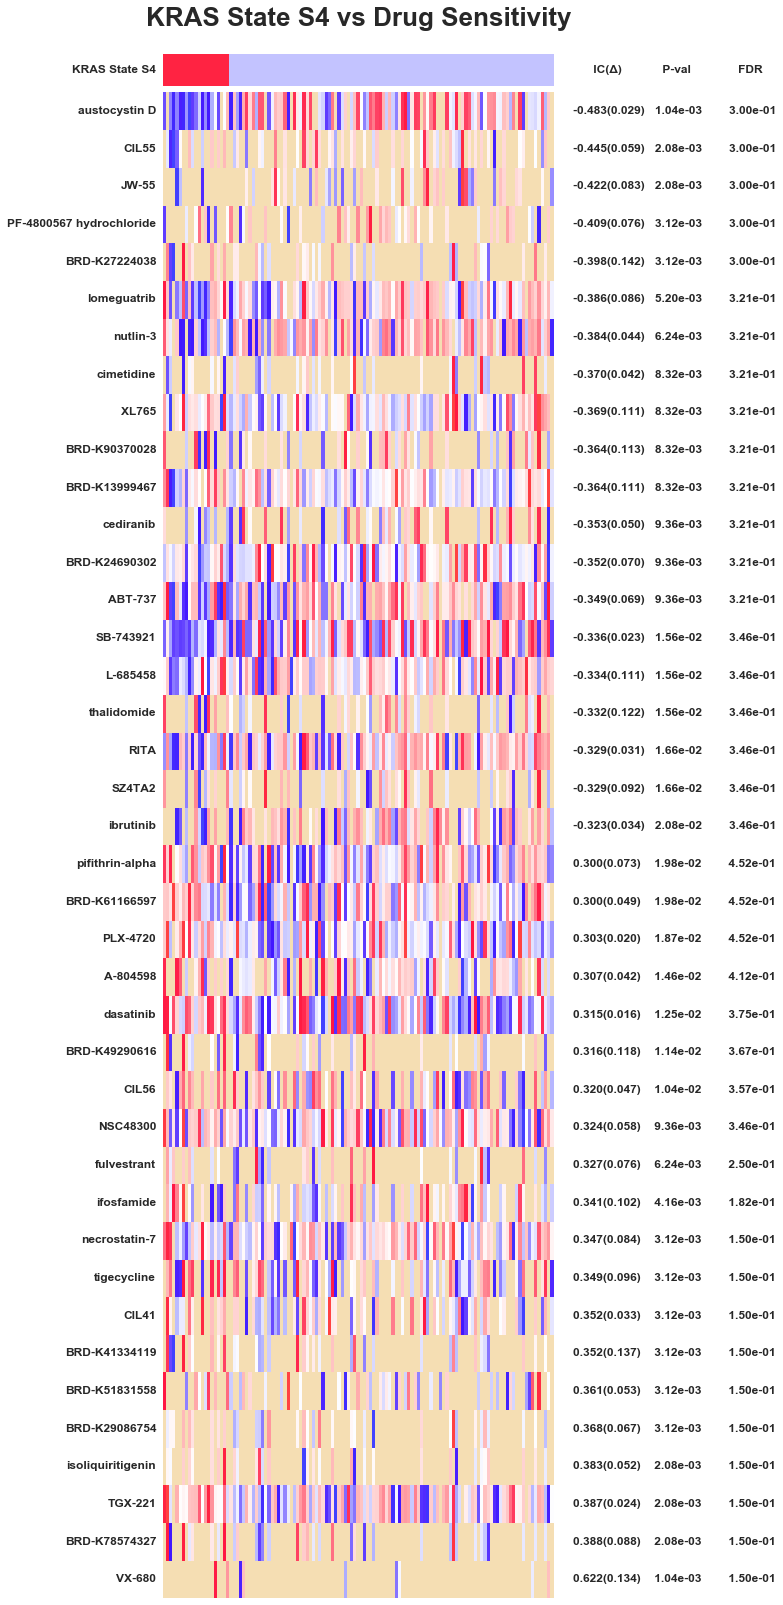

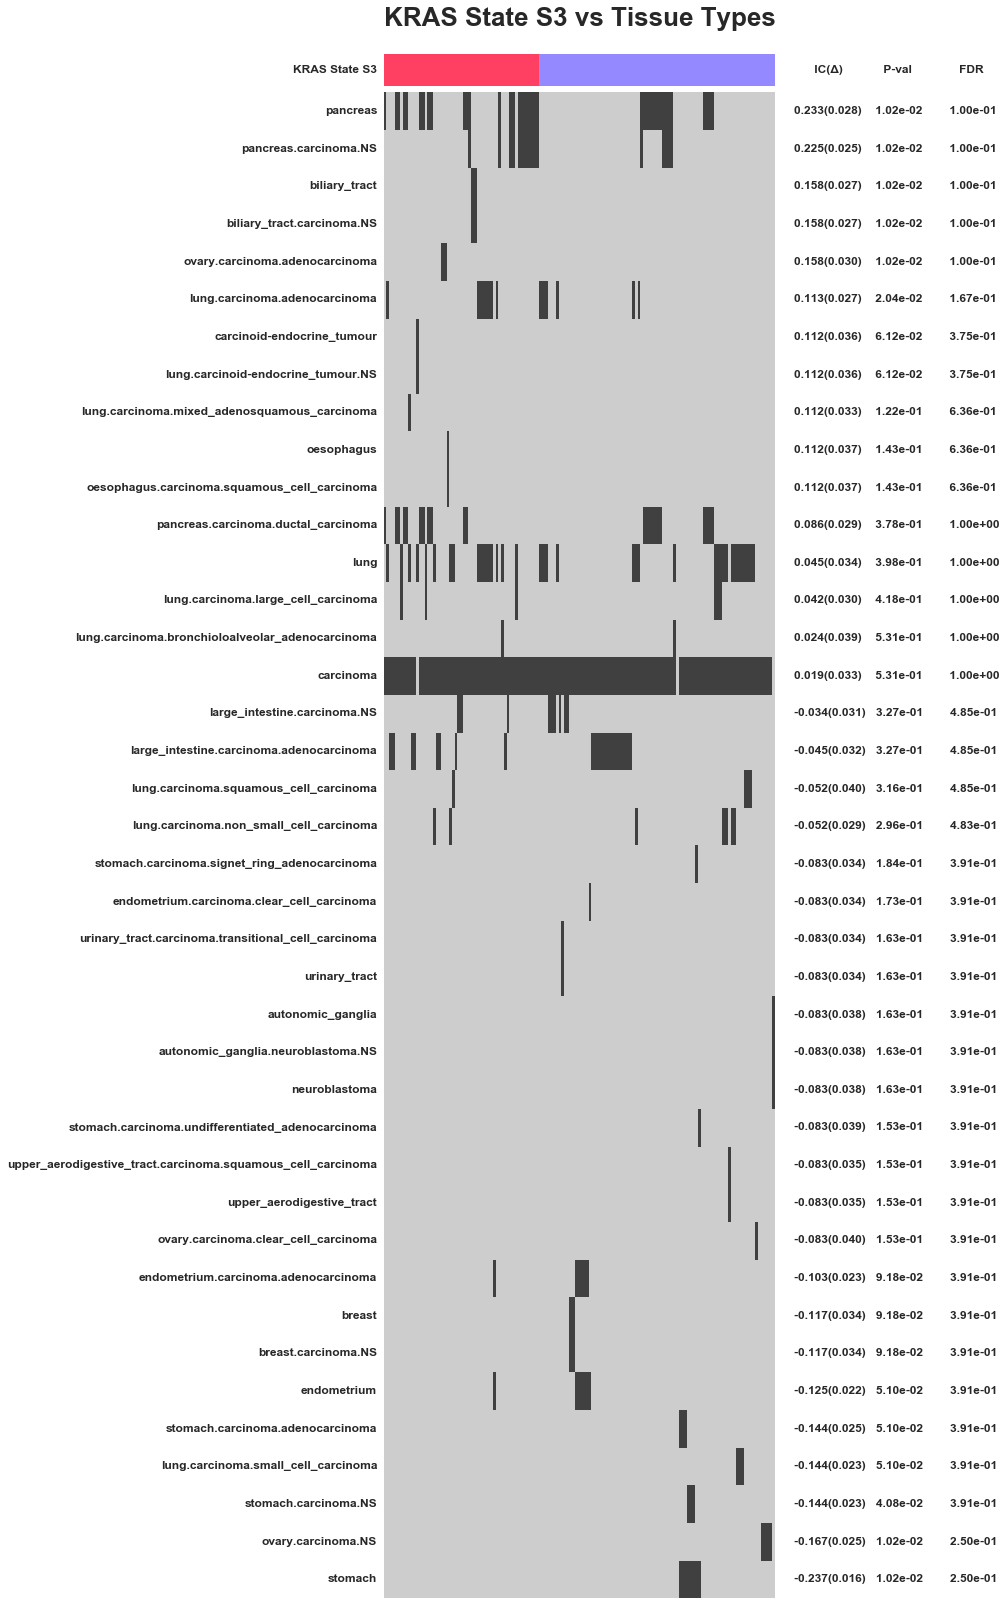

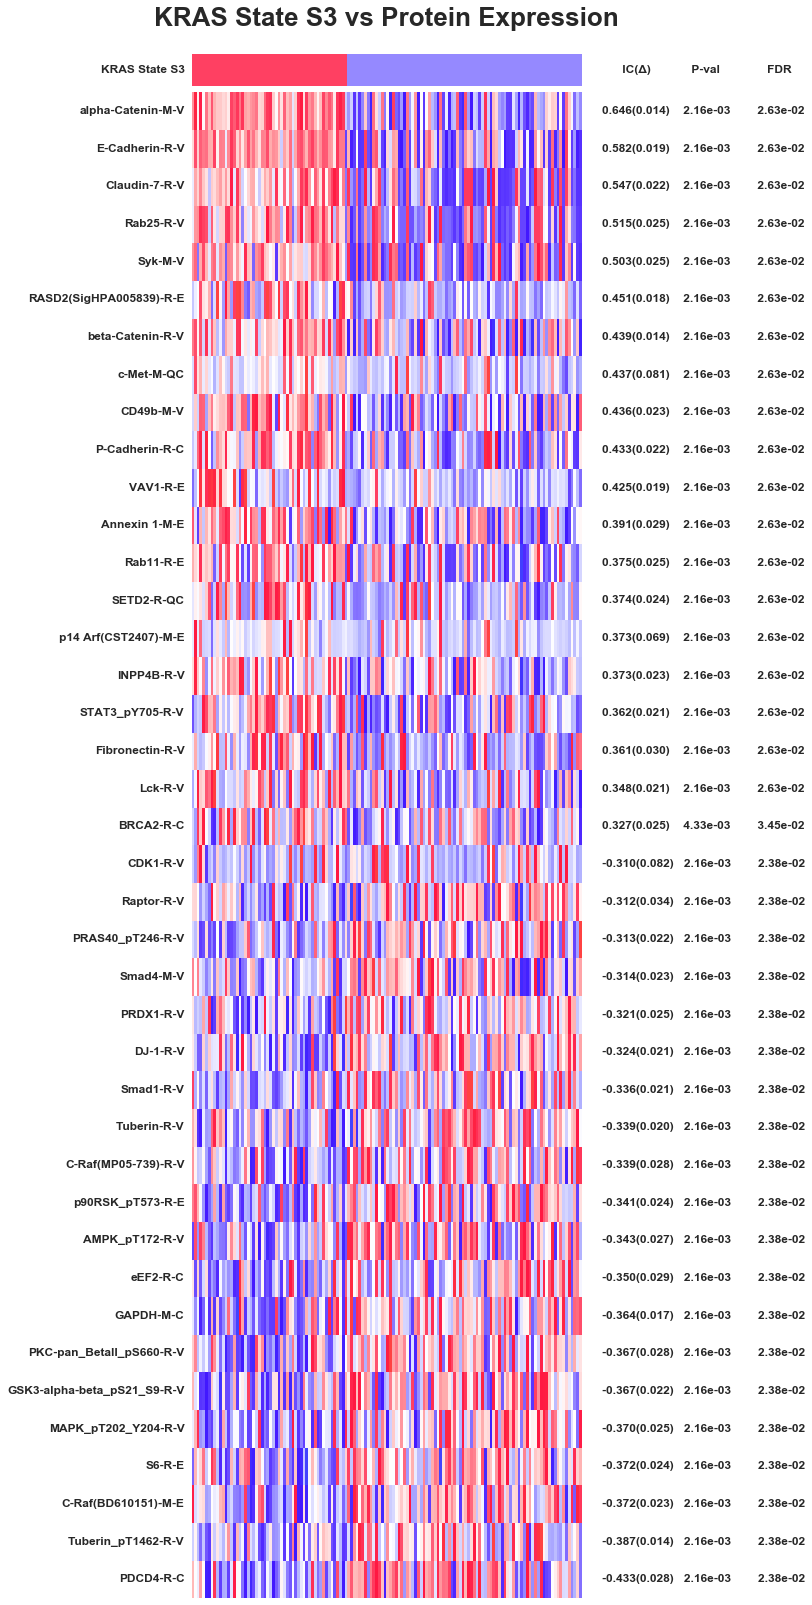

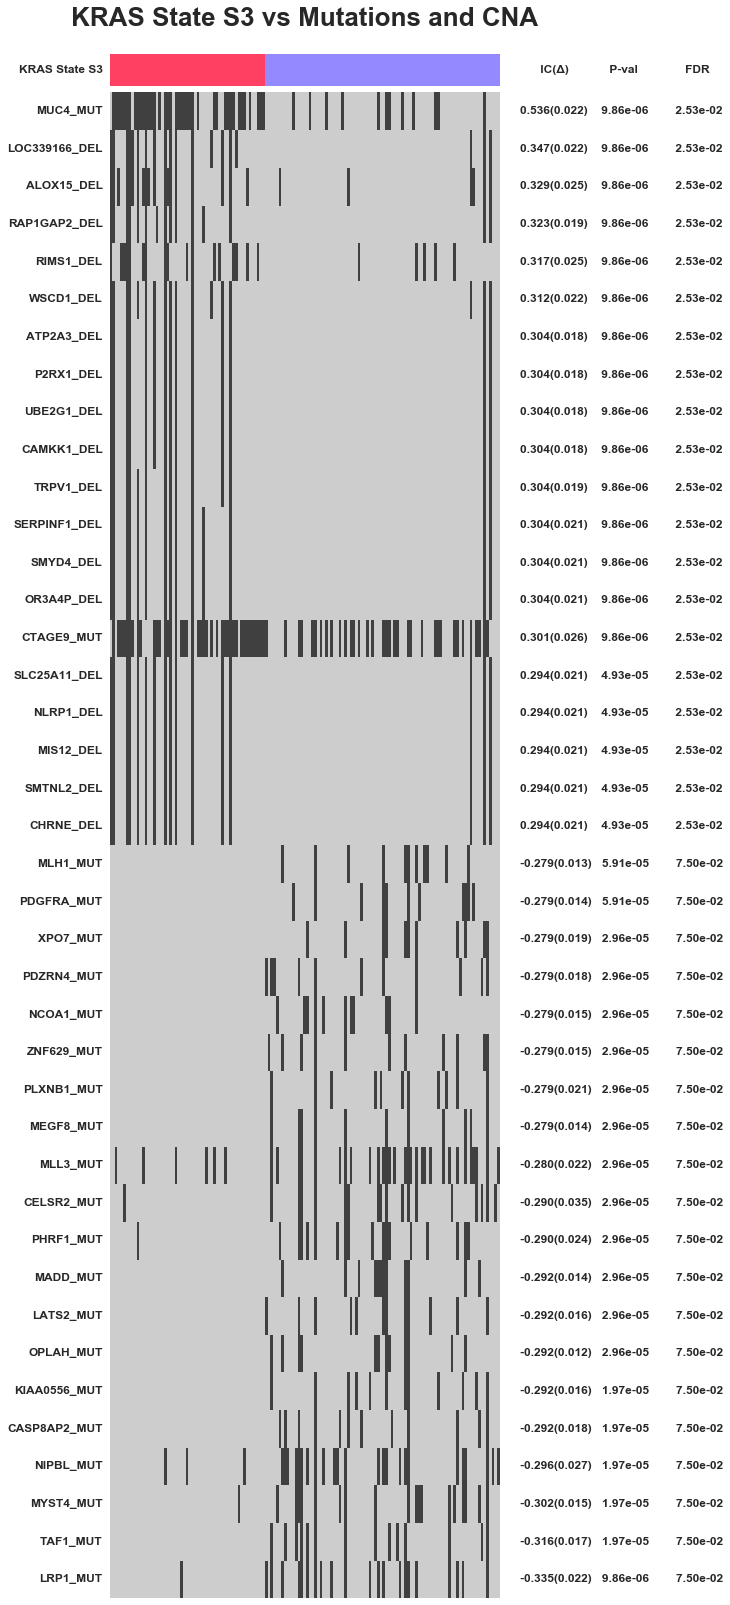

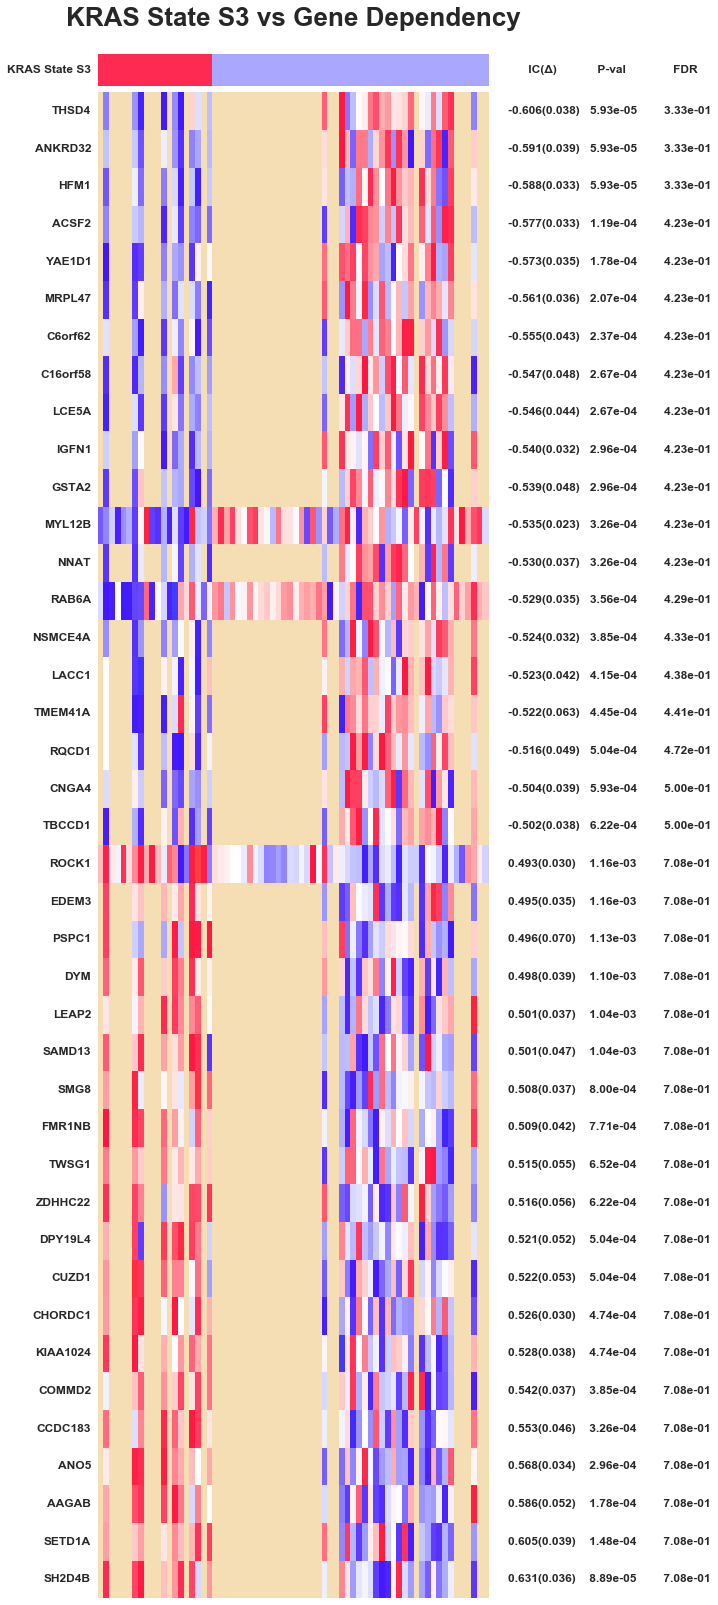

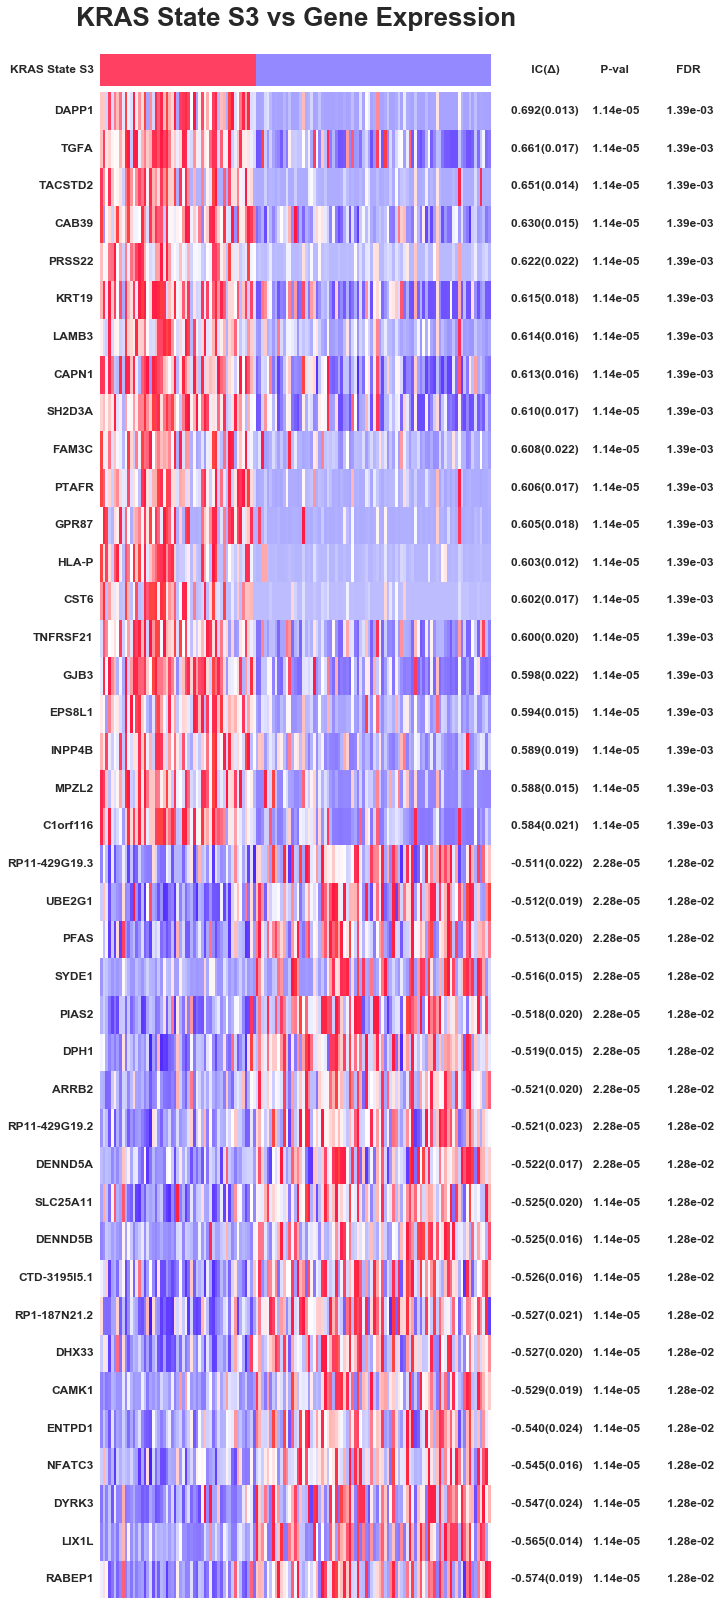

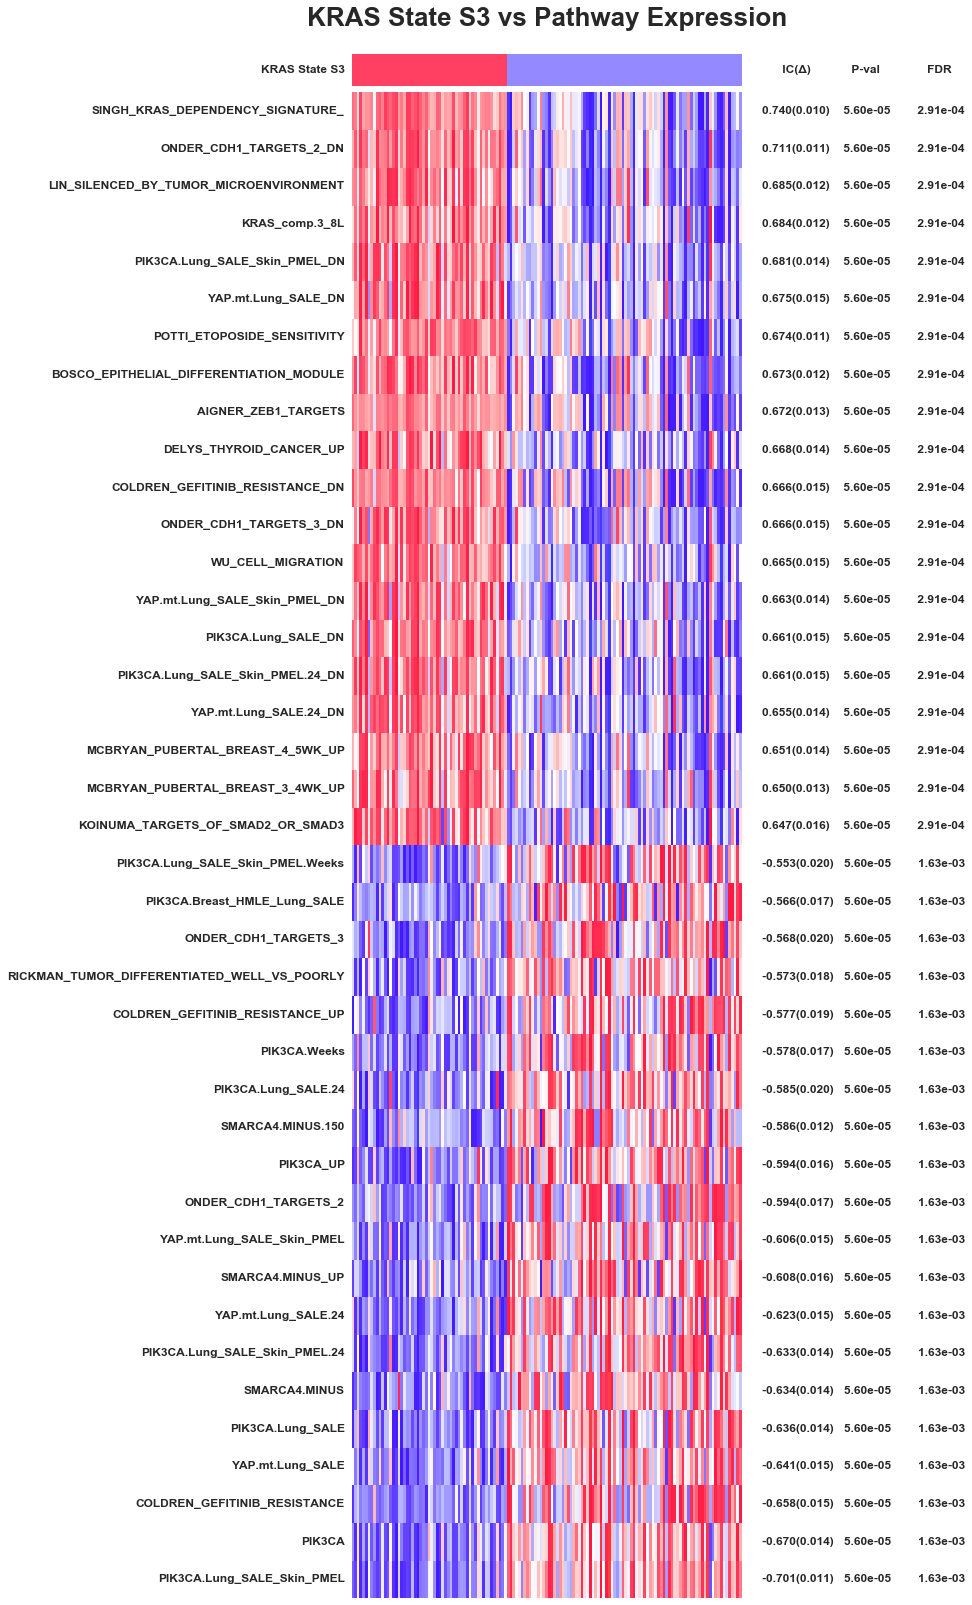

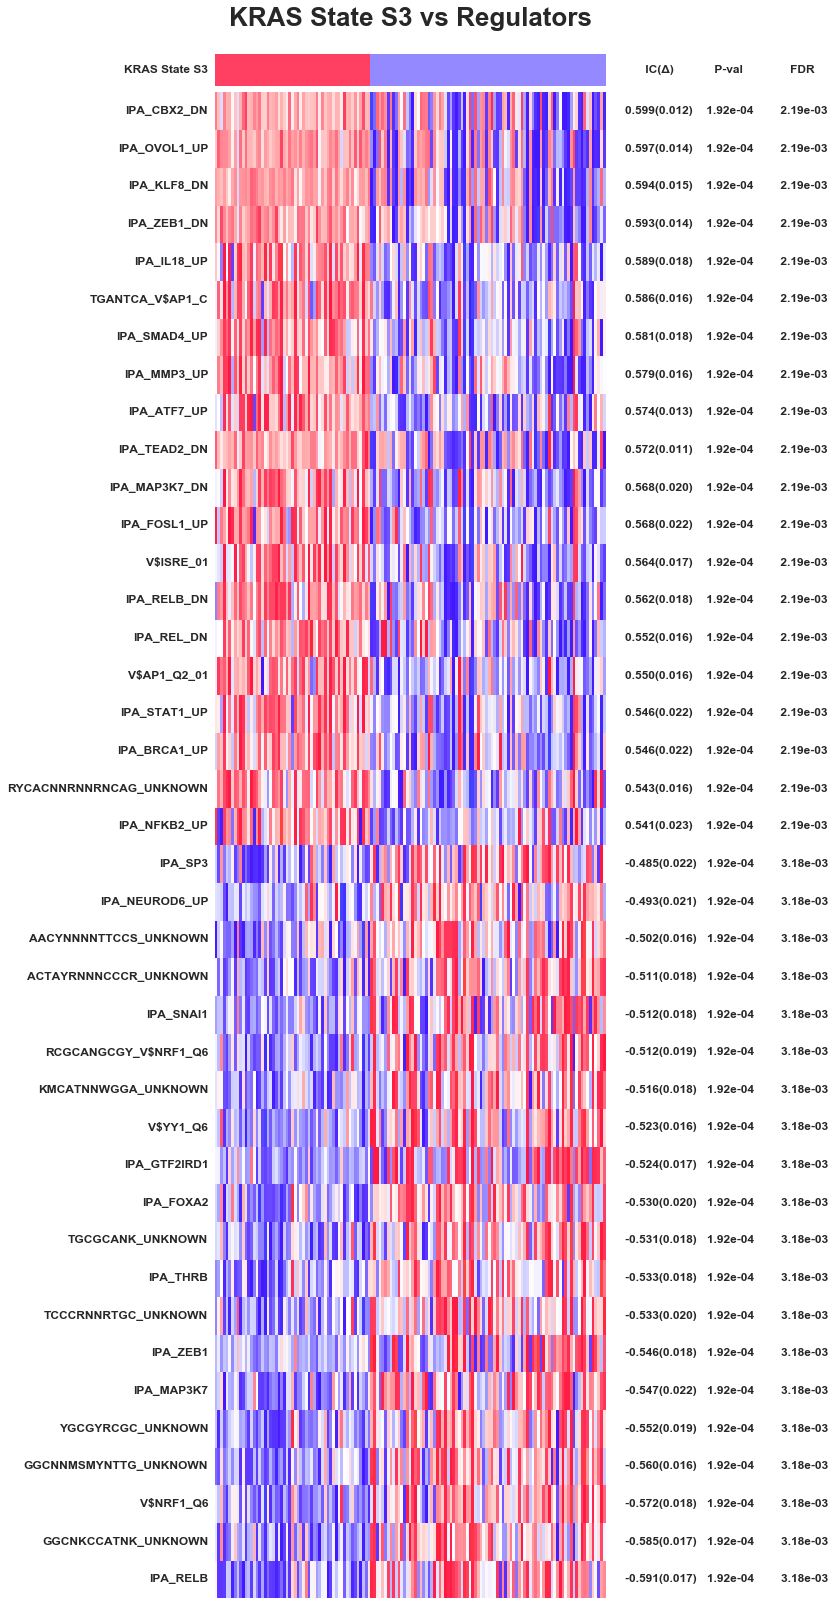

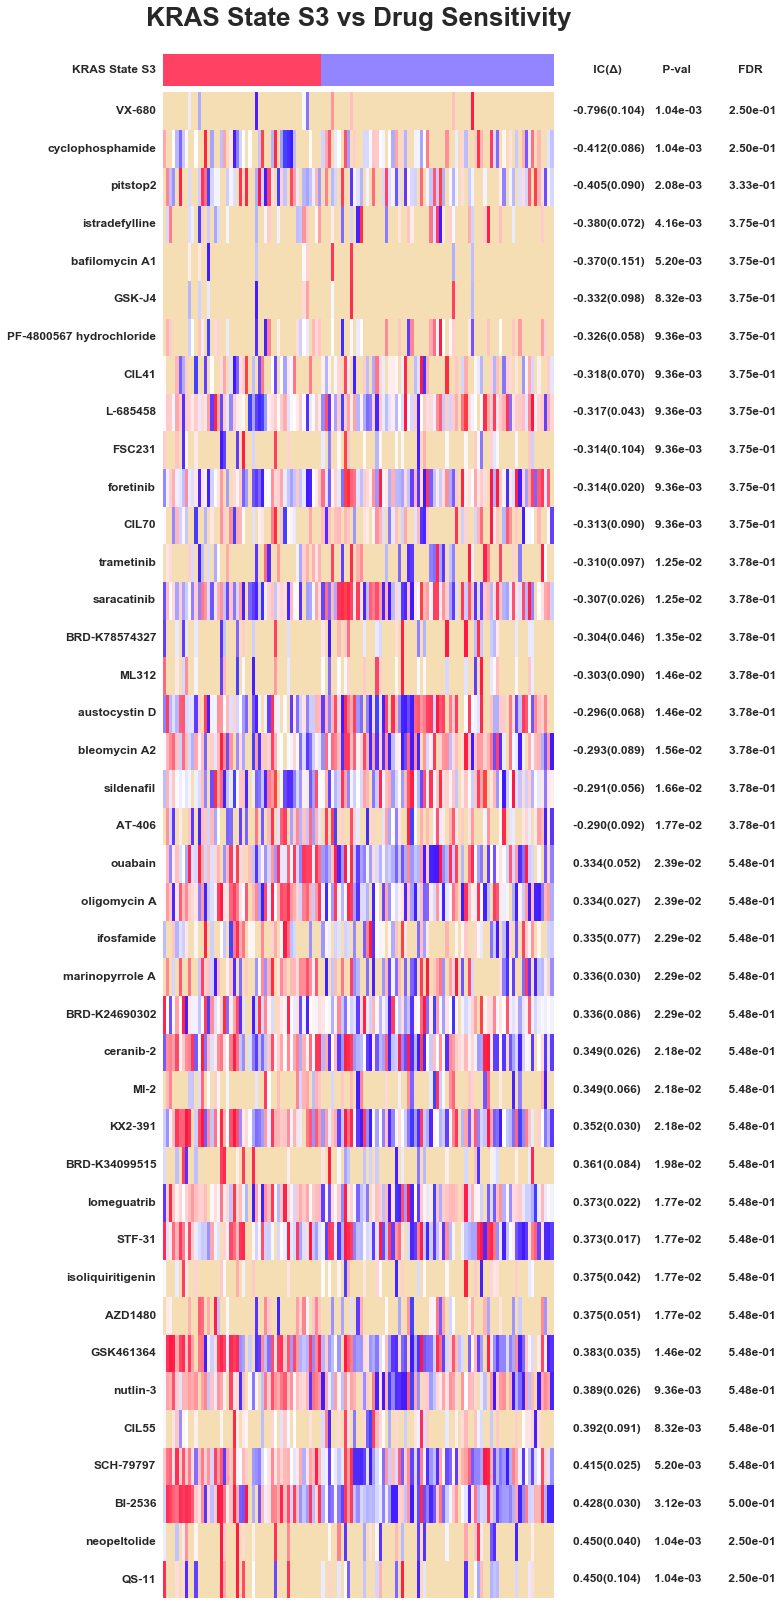

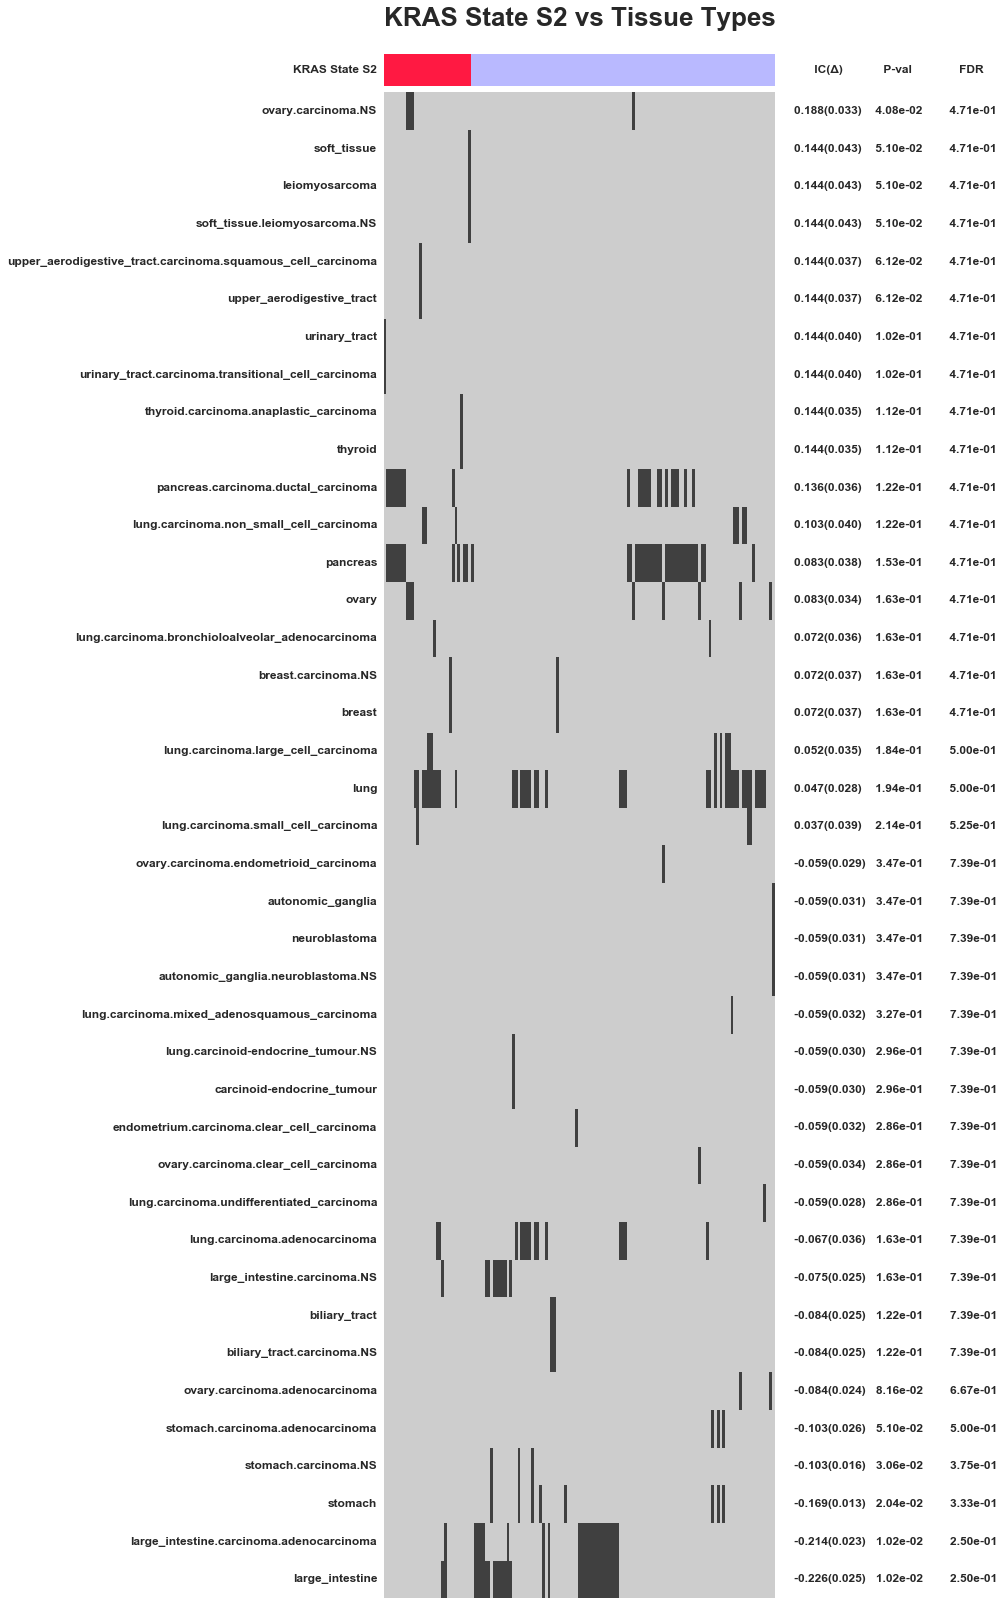

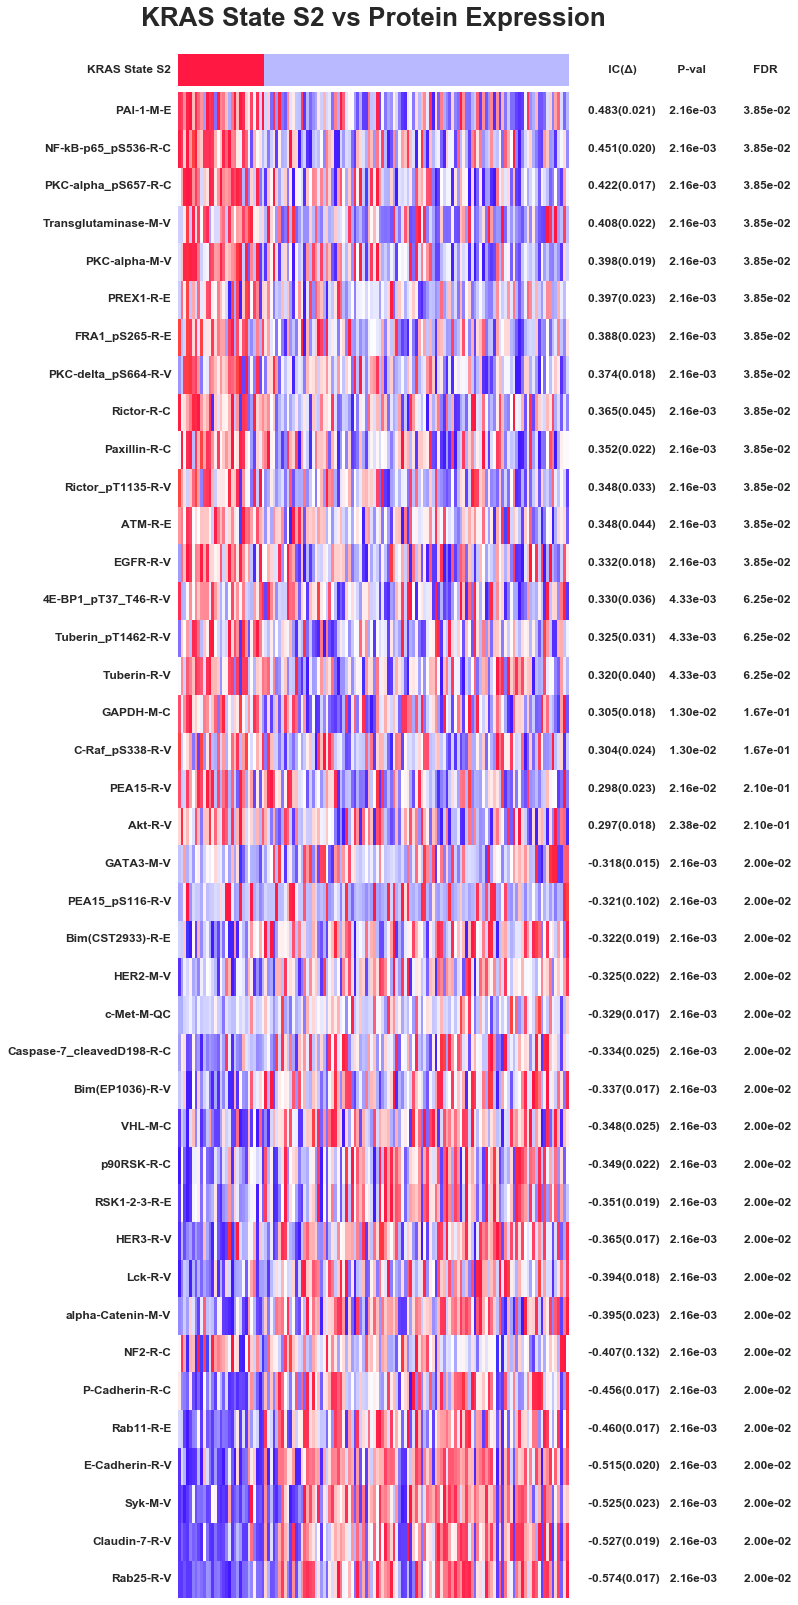

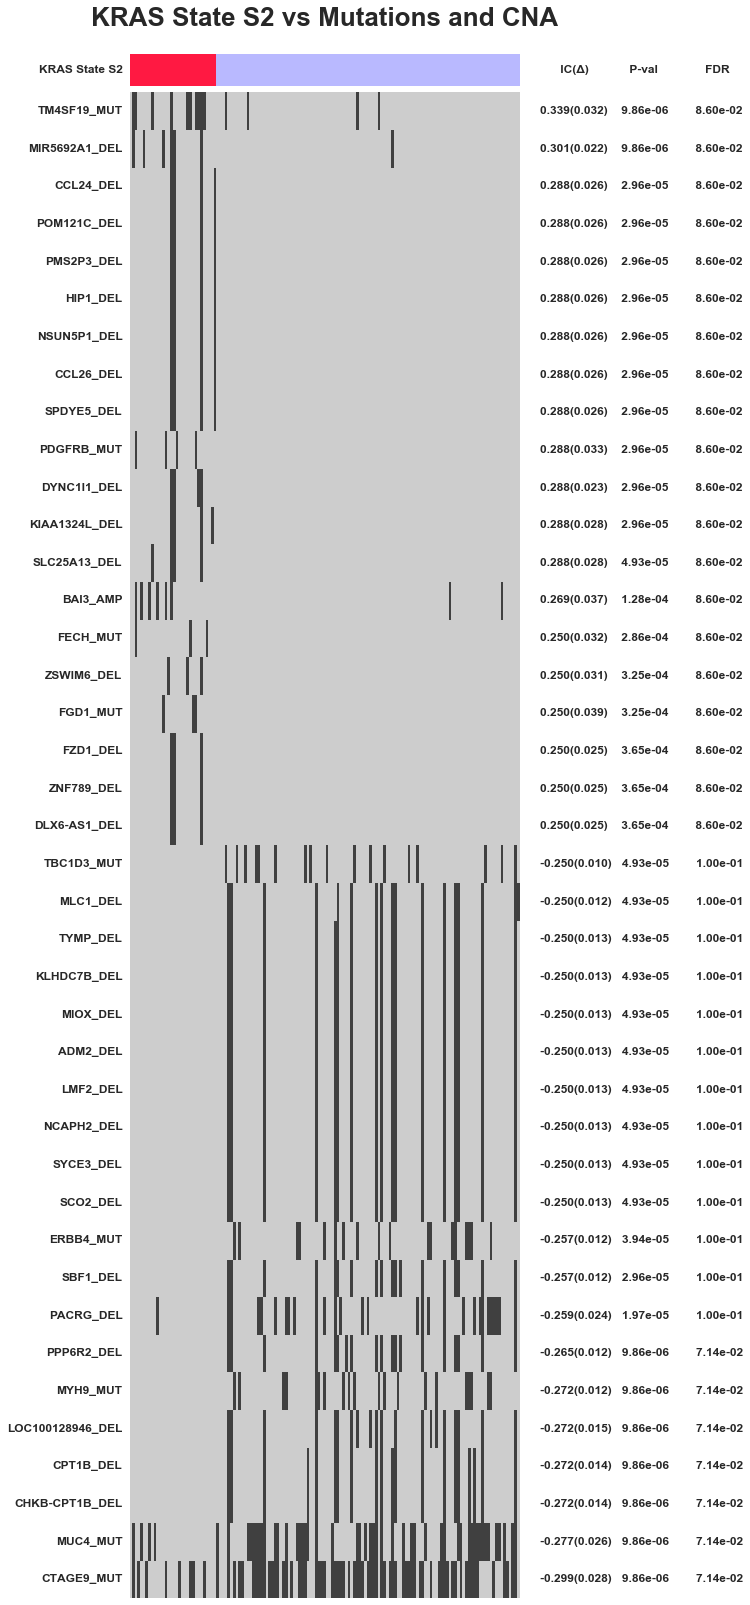

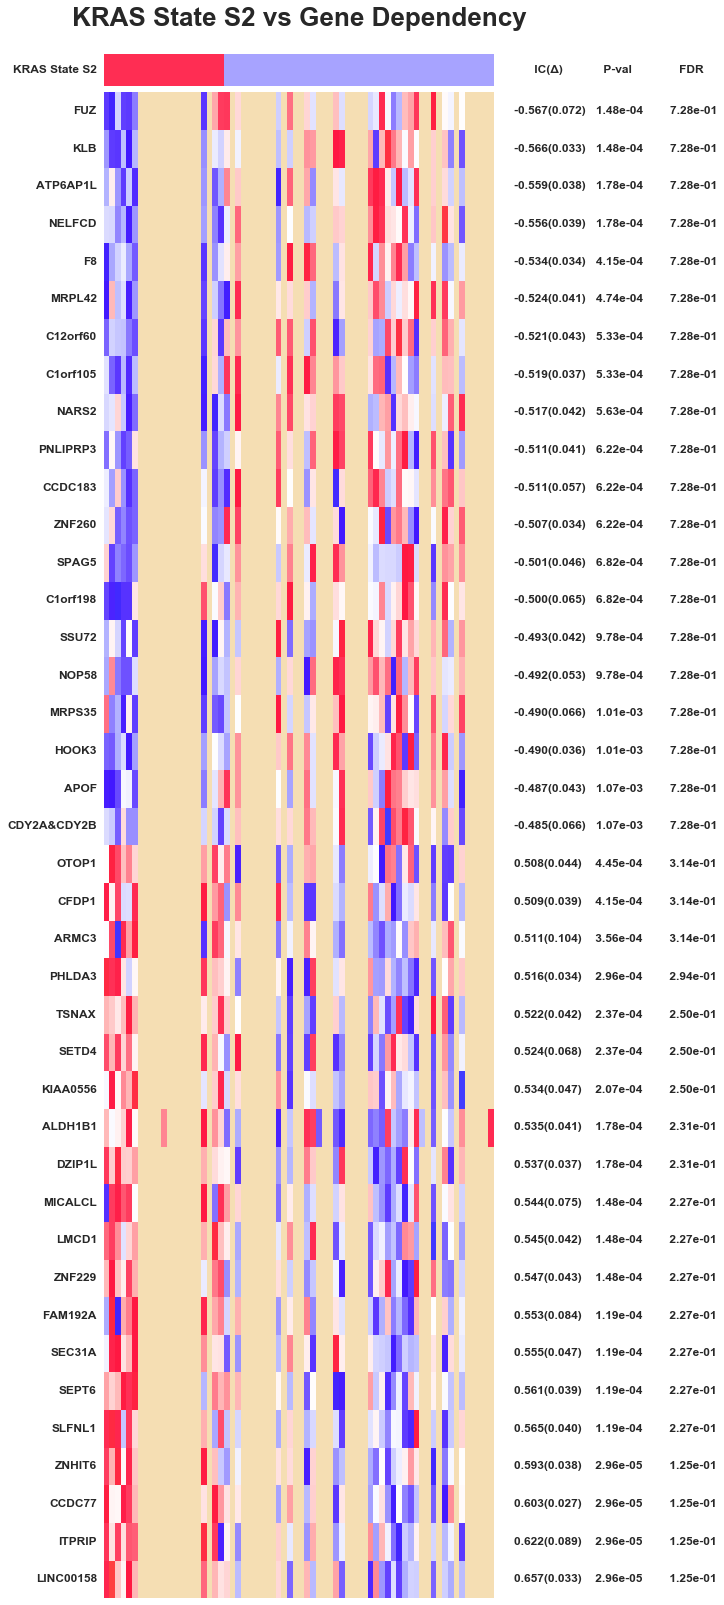

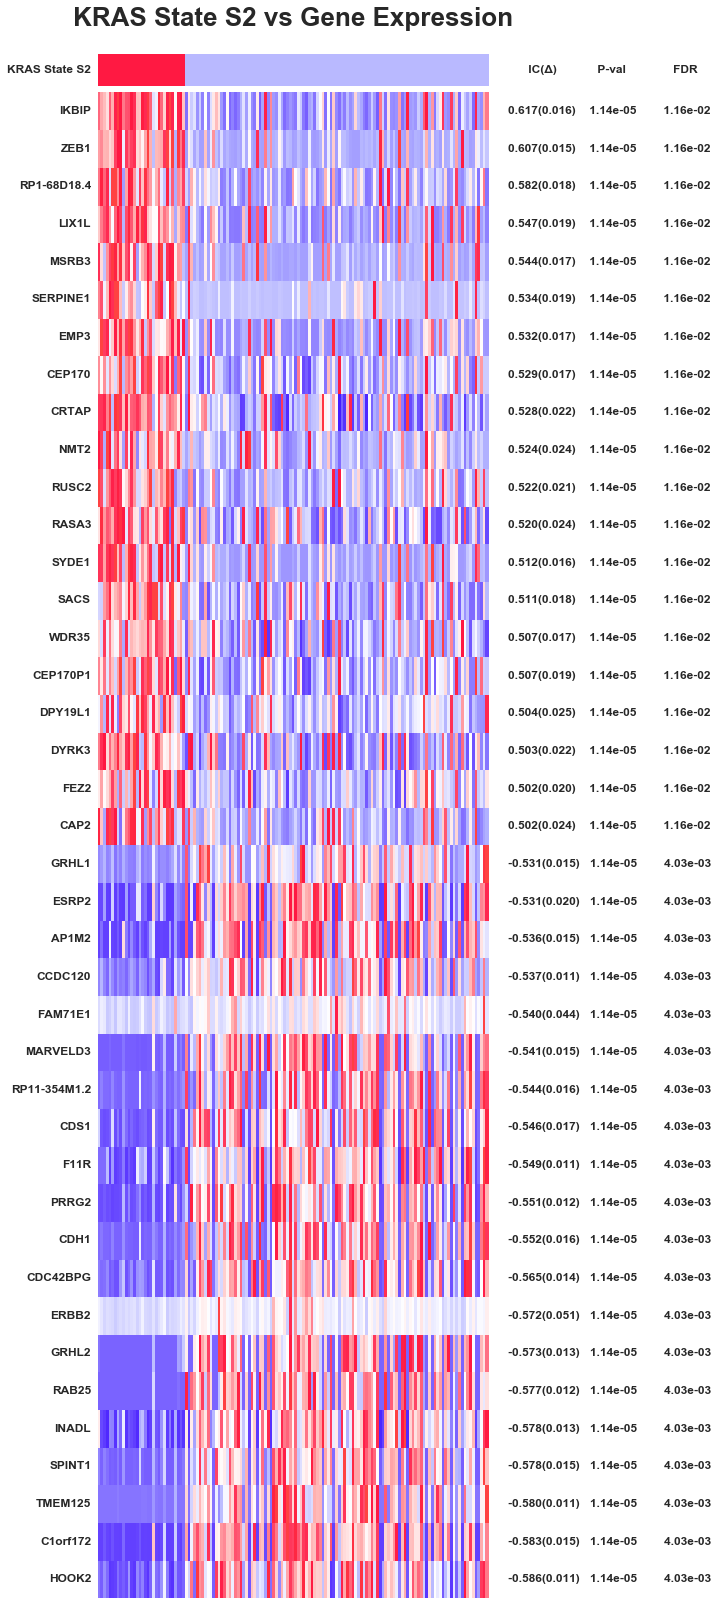

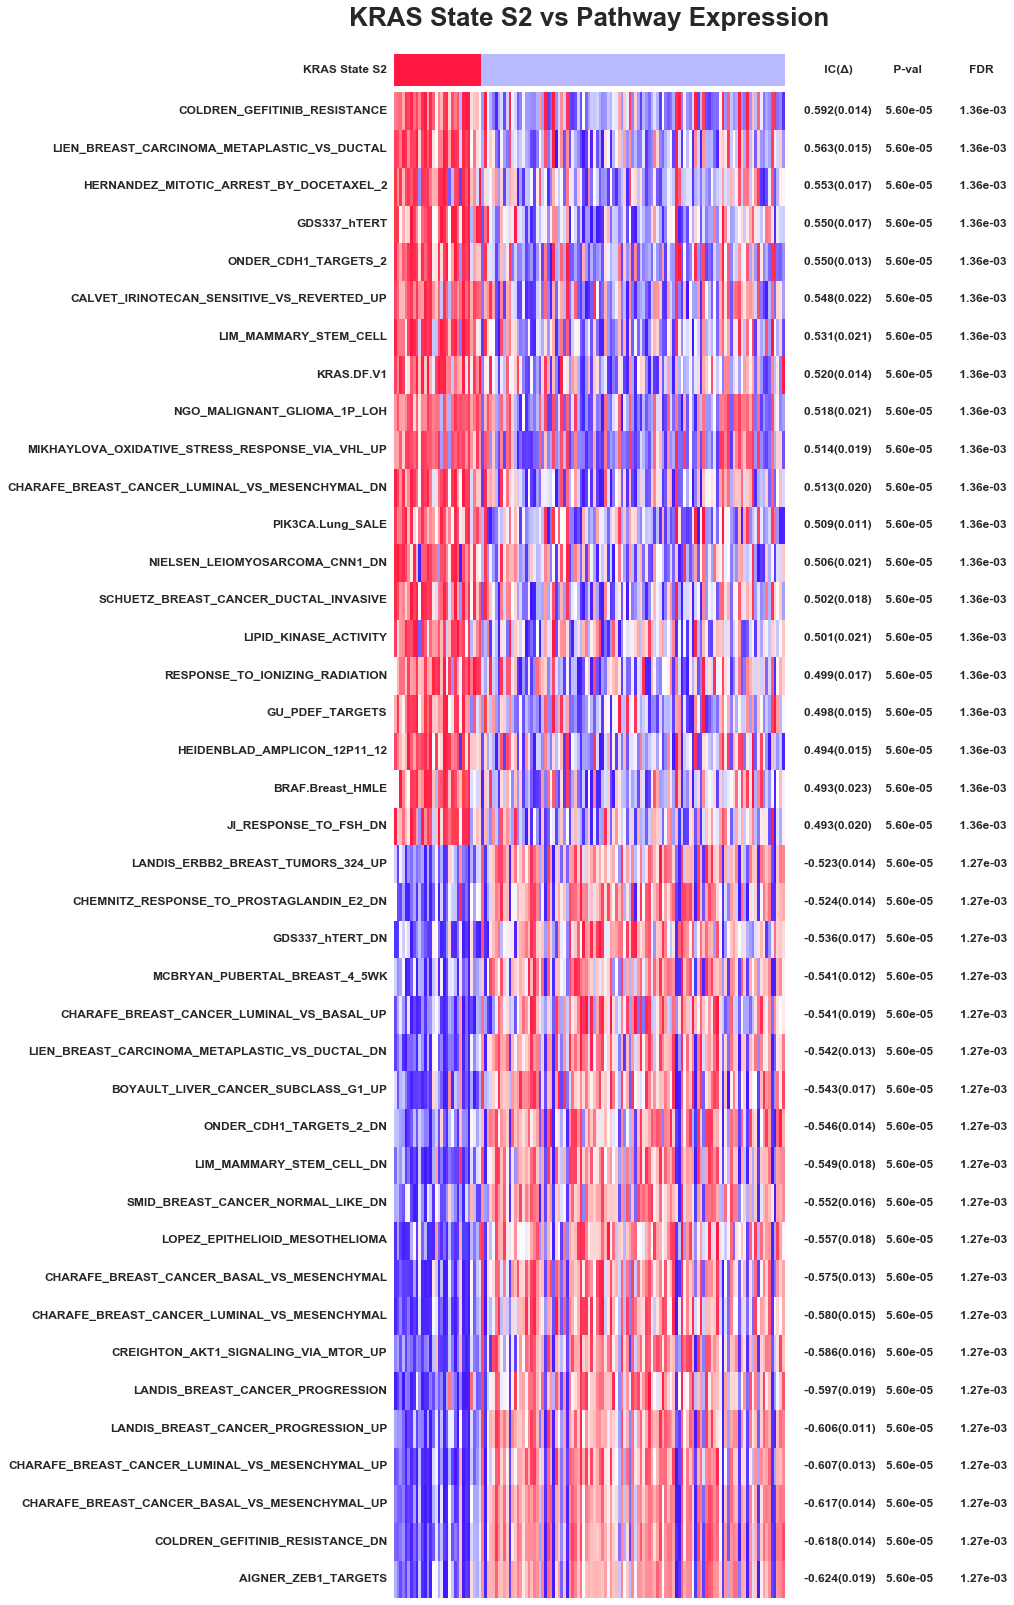

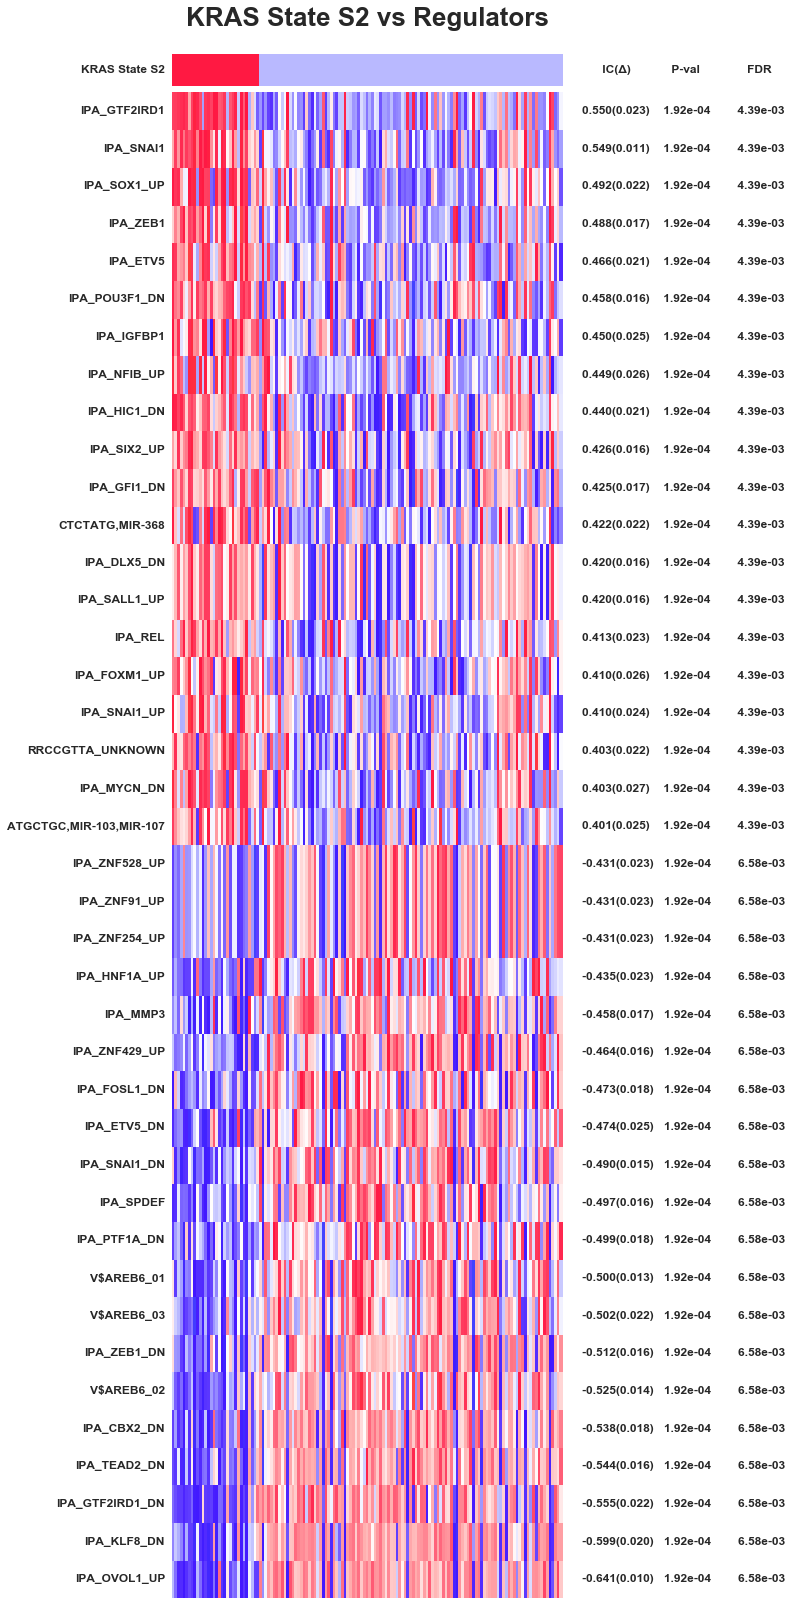

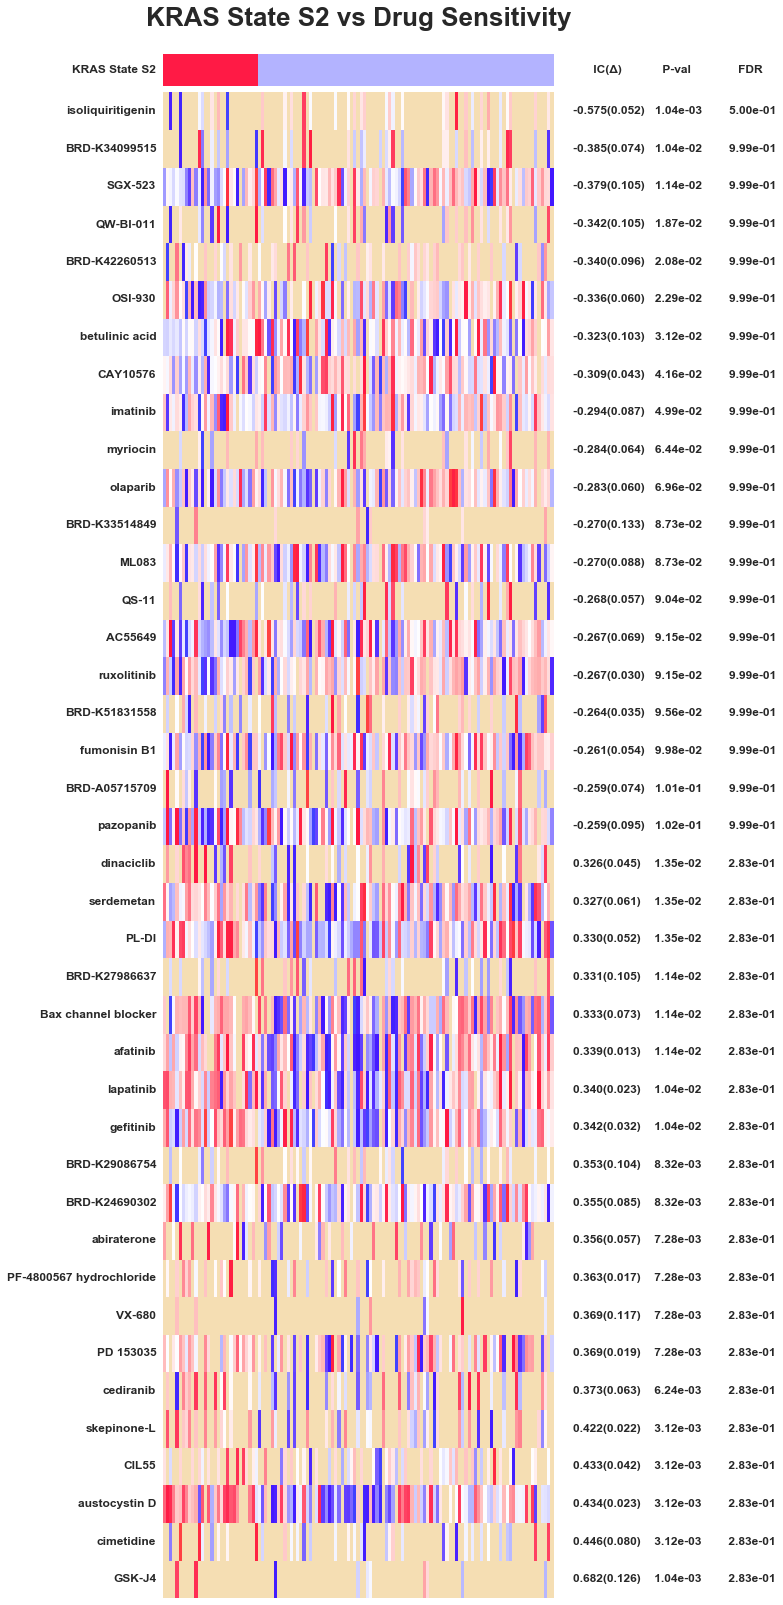

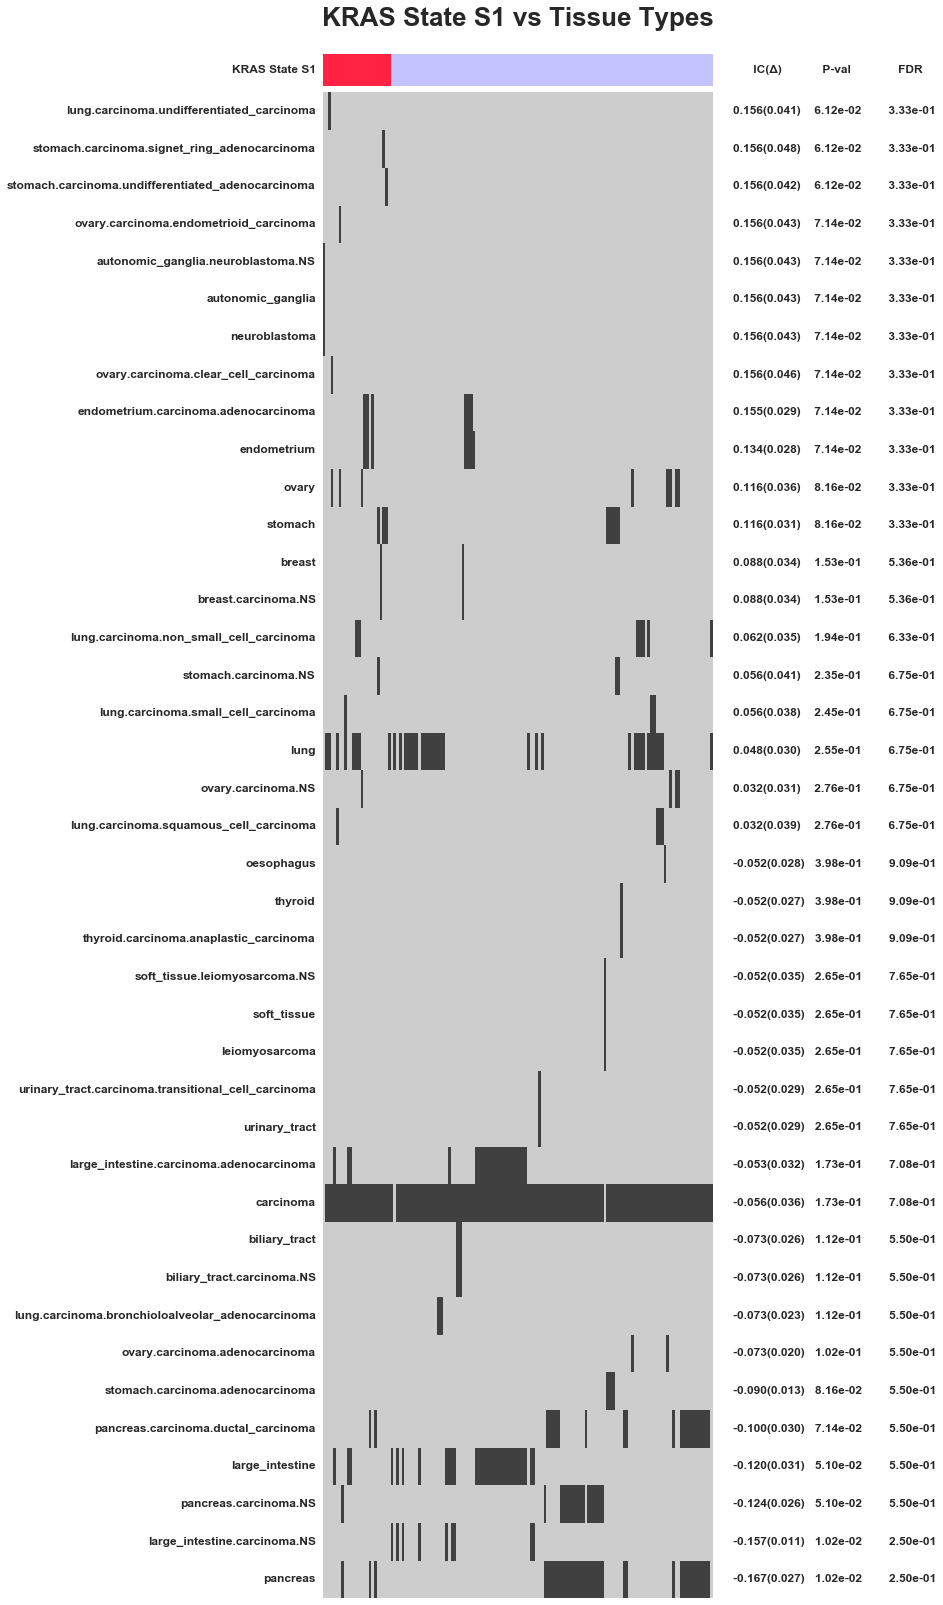

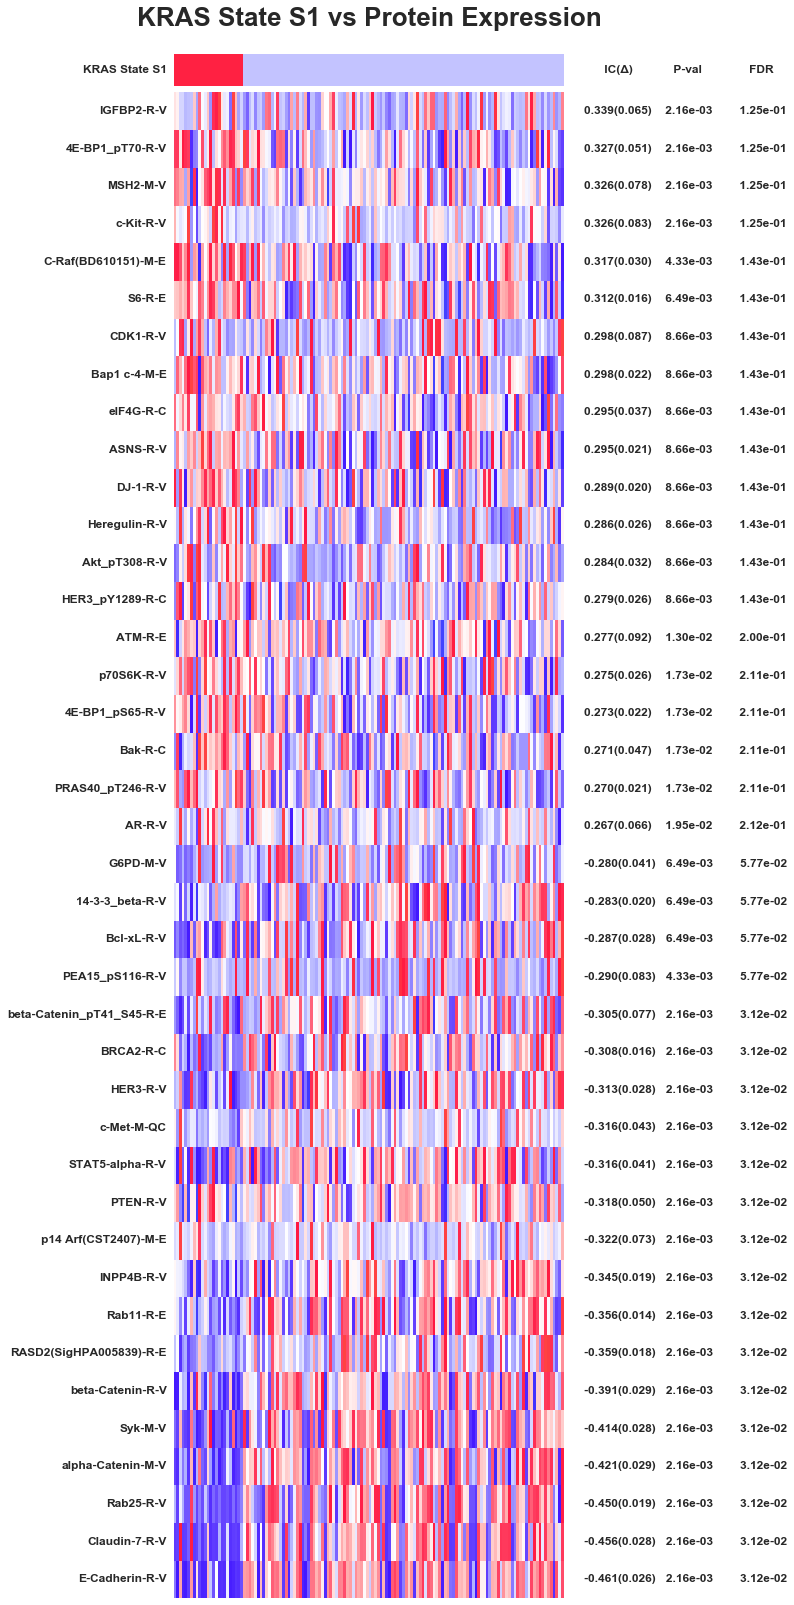

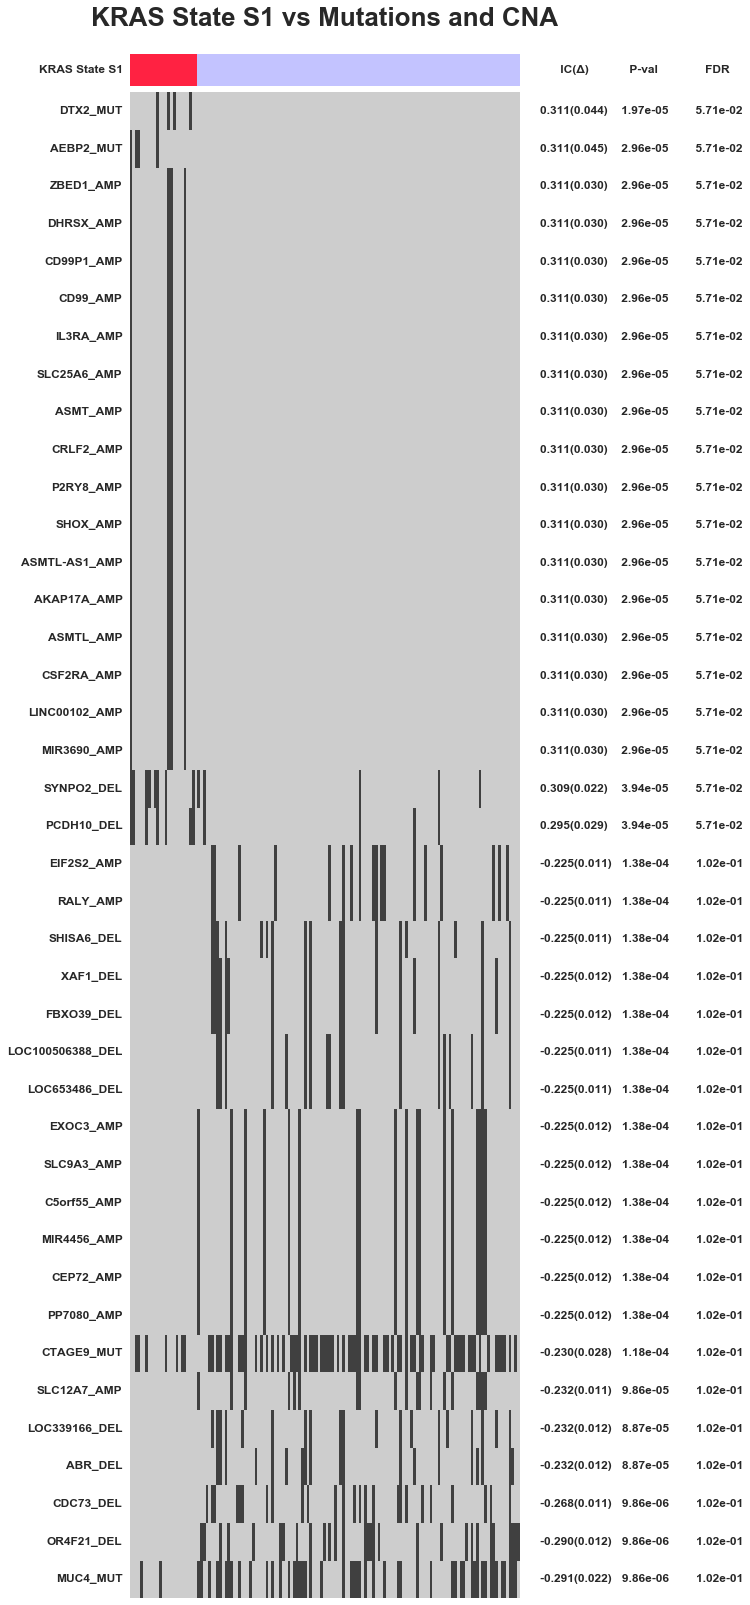

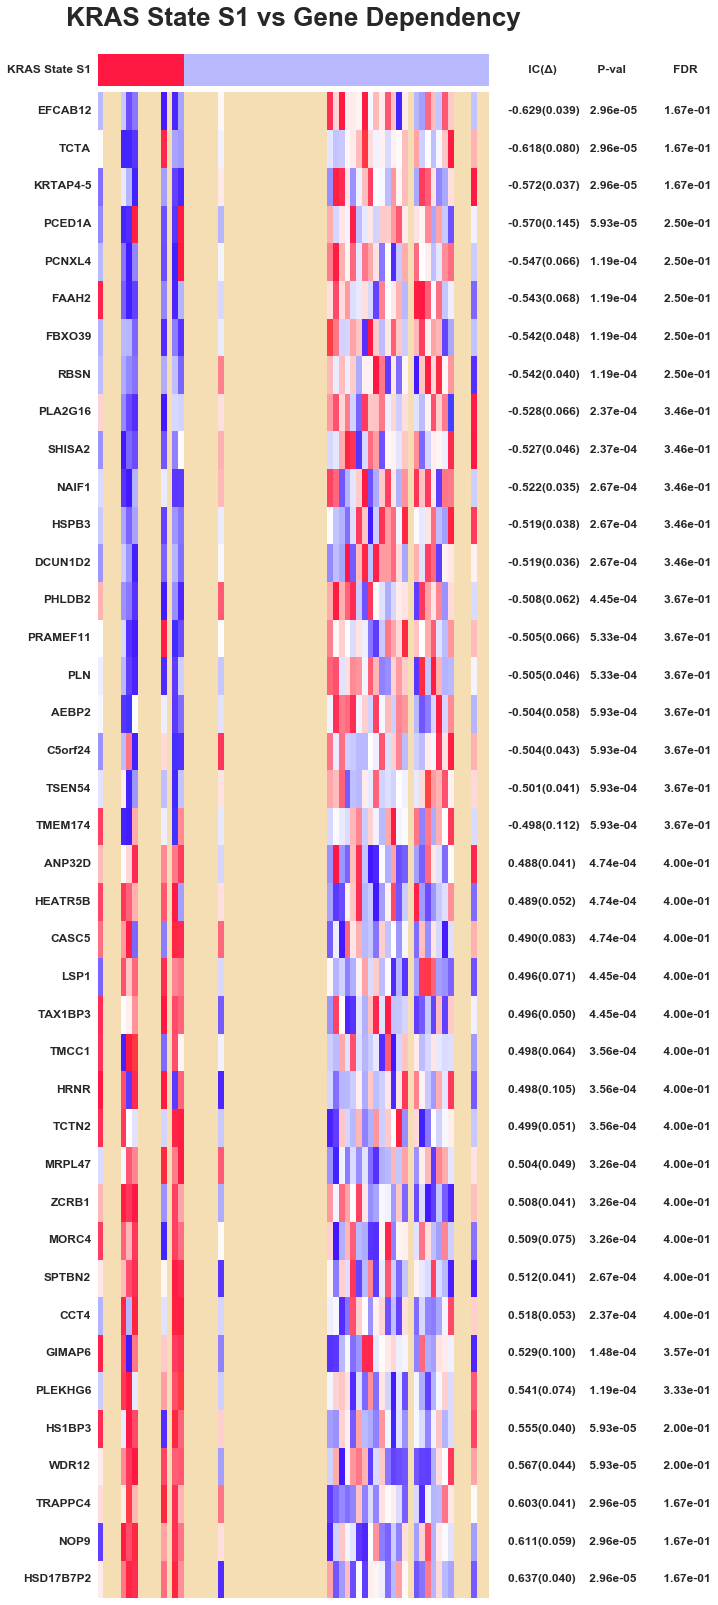

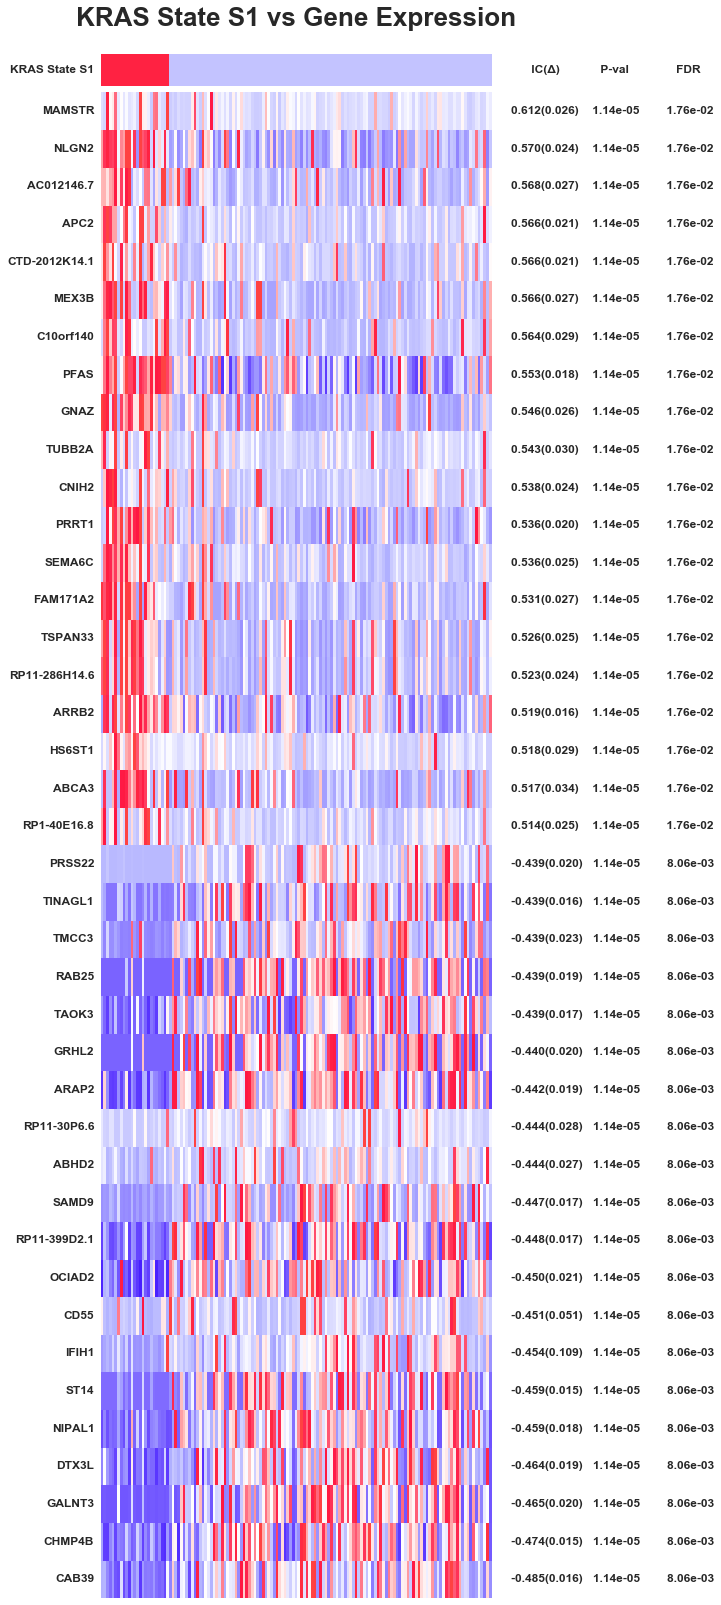

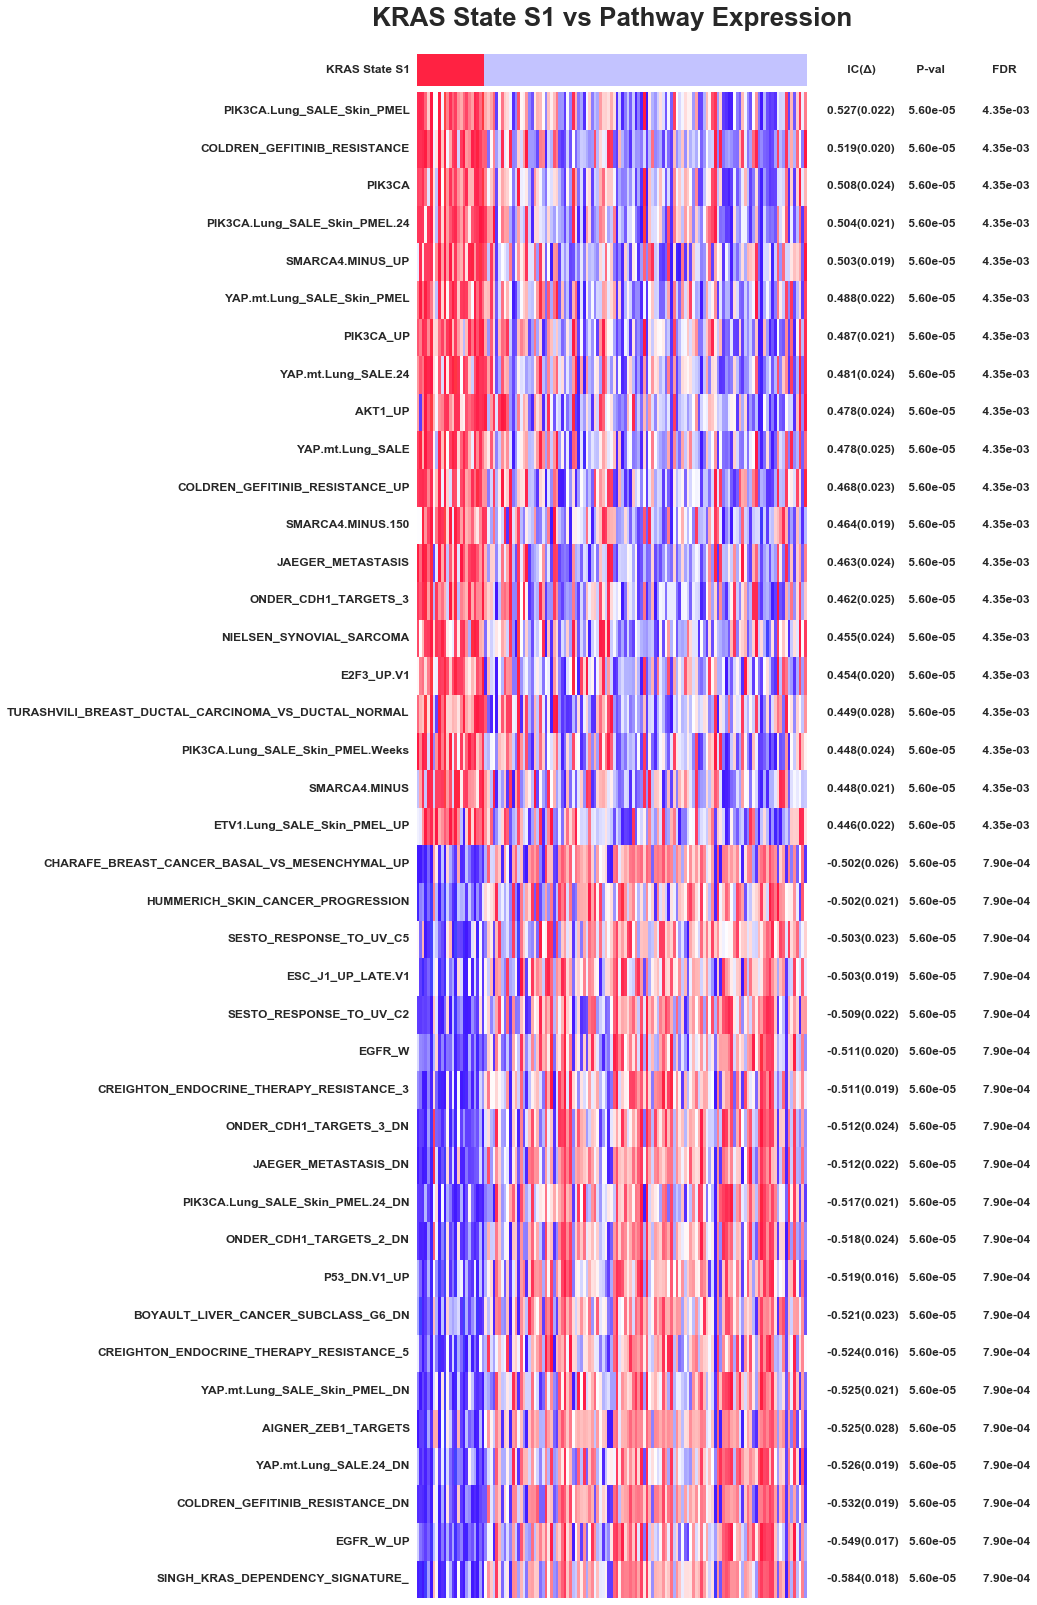

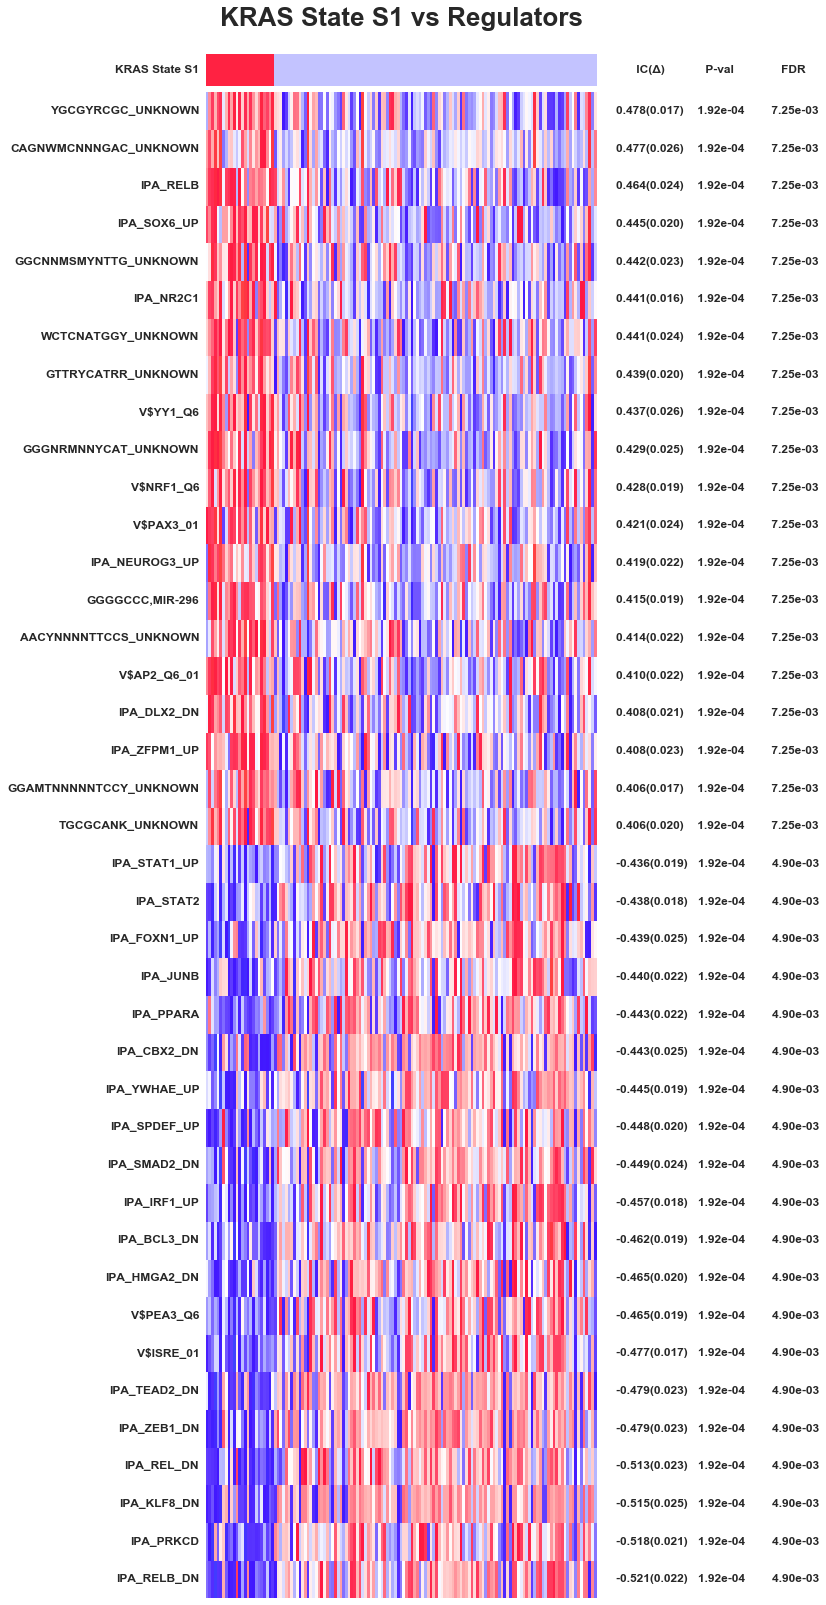

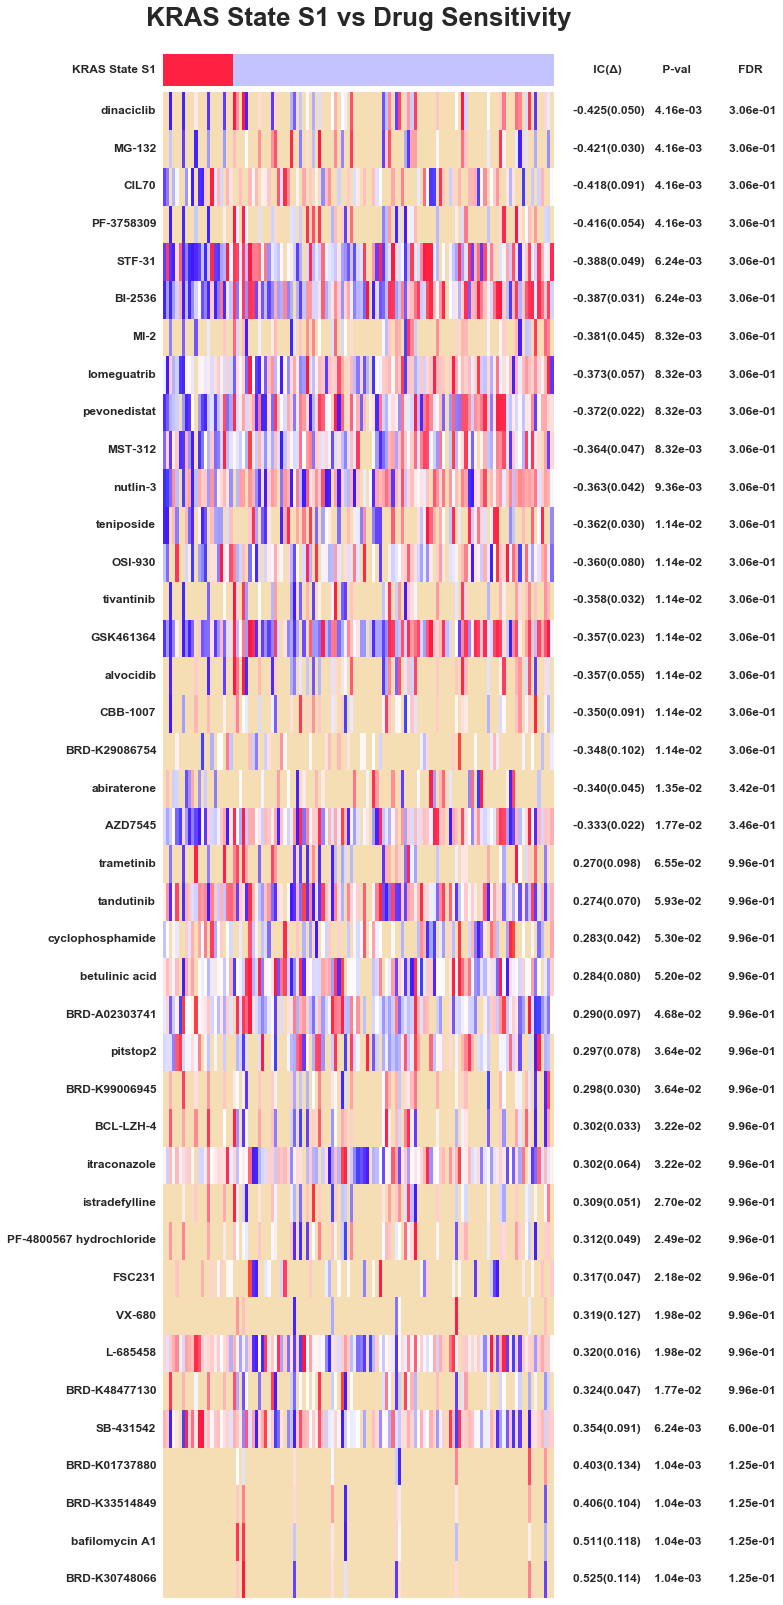

In [7]:
for state in [4, 3, 2, 1]:    
    phenotype = binary_labels.ix[state,:]
    target = pd.Series(phenotype, name='KRAS State S{}'.format(state), index=binary_labels.columns)

    for f in features_bundle:
        print('{} vs {}'.format(target.name, f[0]))
        ccal.association.make_association_panel(target = target, 
                                    features = f[1], 
                                    features_type = f[2], 
                                    n_features = 20,
                                    n_permutations = 0,
                                    title= '{} vs {}'.format(target.name, f[0]),  
                                    features_ascending = f[3],
                                    filepath_prefix= RESULTS_DIR + '/S{}'.format(state) + '/kras_state_S{}_vs_{}'.format(state, f[0]),
                                    random_seed = 12345)  